#    
# Team 4 Destaurant : Sberbank Russian Housing Market 

###          

 - 팀원 : 허성현, 신정원, 조성빈
 - 주제 : 러시아 Sberbank에서 고객에게 제공하기 위한 러시아 부동산 가격 예측 모델 선정
###            

--------------------------------------------------------------------------------------------------------------------------------

# Contents


|  <h2> 1. Explore Data Analysis <h2/>  |  <h2> 2. Feature Selection <h2/>    | <h2> 3. Model Optimization & Results<h2/>|
| :-------------------------------------- | :-------------------------------------- | :-------------------------------------- |
|  <h3> * Neighbourhood, Macro 변수 탐색 <h3>     | <h3> * 변수 선정 <h3/>                   | <h3> * CV 후 수정 및 모델 분석 <h3/>     |
|  Neighbourhood, Macro                           |  변수선택(Backward Elimination, 반복제거) |  크로스 밸리데이션 및 모델 분석, 수정     |
|  종속, 카테고리, 누메릭 변수              |  R-Style 분석 및 최적화                   |                                        |




 


# * Env setting

In [88]:
###############################################  set environment  ###############################################
# pd.set_option('display.height', 1000)
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

# * Importing

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math as m
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import time

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# * Function Handling Part

In [2]:
###############################################  read data  ###############################################
def read_csv():
    #train = pd.read_csv('datasets/original_data/train.csv')
#     train = pd.read_csv('datasets/processed_data/treated_train_df.csv')
#     train = pd.read_csv('datasets/processed_data/train_df_treated_20171021.csv')
#     train = pd.read_csv('datasets/processed_data/train_tr_byear_sta_20171023.csv')
    train_df = pd.read_csv('datasets/processed_data/train_processed_20171127_df.csv')

#     m_train = pd.read_csv('datasets/original_data/macro.csv')   
#     m_train = pd.read_csv('datasets/processed_data/macro_train_imputated_df_20171023.csv')
    macro_df = pd.read_csv('datasets/processed_data/macro_processed_by_fillna_median_20171125.csv')
    
    test_df = pd.read_csv('datasets/processed_data/test_processed_20171125_df.csv')
    return train_df, macro_df, test_df

###############################################  encoding part  ###############################################
#Encoding Categorical Variables
def encode_cat(df):
    """
       Input : train_df 
       Output : encoded_train_df
    """
    #get categorical(type='object') variable
    cat_var_df = df.select_dtypes(include=['object']).copy()
    
    
    cleanup_nums = {"product_type":{'OwnerOccupier' : 0, 'Investment' : 1},                
               "ecology": {'no data' : 0, 'poor' : 1, 'satisfactory' : 2, 'good' : 3, 'excellent' : 4}}
    
    #dummy encoding
    for i in cat_var_df.columns:        
        if cat_var_df[i].unique()[0] in ['no', 'yes']:
            cleanup_nums[i] = {'no':0, 'yes':1}
    
    #sub_area encoding
    sub_index = 0
    sub_area_enc_dict = {}
    for key in set(cat_var_df['sub_area'].values):
        sub_area_enc_dict[key] = sub_index
        sub_index += 1
    cleanup_nums['sub_area'] = sub_area_enc_dict
    
    try:
        cat_var_df.replace(cleanup_nums, inplace=True)
    except:
        pass
    
    df = df.drop(cat_var_df.columns, axis=1)
    df = pd.concat([df, cat_var_df], axis=1)
    return df

#encode macro cat variable
def m_encode_cat(df):
    """
       Input : macro_df
       Output : encoded_macro_df
    """
    #get categorical(type='object') variable
    cat_var_df = df.select_dtypes(include=['object']).copy()
    
    
    cleanup_nums = {"child_on_acc_pre_school":{'#!' : 0, '3,013' : 1, '7,311' : 2, '16,765' : 3, '45,713' : 4},                
                "modern_education_share": {'90,92' : 1, '93,08' : 1, '95,4918' : 2},
                "old_education_build_share": {'23,14' : 1, '25,47' : 1, '8,2517' : 2}}
           
    try:
        cat_var_df.replace(cleanup_nums, inplace=True)
    except:
        pass
    
    df = df.drop(cat_var_df.columns, axis=1)
    df = pd.concat([df, cat_var_df], axis=1)
    return df

#encoding numeric var
def encode_num(df):
    """
       Input : train_numeric_variables_column_df
       Output : encoded_train_numeric_variables_column_df
    """
    df['build_year']  = abs(df['build_year'] - 2011) #1900?
    return df

###############################################  outliers handling part  ###############################################
#dropping outliers by fox_criteria
def dropping_outliers1(x, y):
    """
       Input : x = 'independent_variables_df', y = 'dependent_variable_df'
       Process : Remove Outlier-Rows by Fox-Recommendation
       Output : x without Outlier-Rows, y without Outlier-Rows
    """
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1)
    result = model.fit()
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (len(y) - len(x.columns) -1)
    idx = np.where(cooks_d2 > fox_cr)[0]
    x = x.drop(x.index[idx])
    y = y.drop(y.index[idx])
    print("Function dropping_outliers :" + str(len(idx)) + ' rows have beed deleted')
    return x, y

###############################################  feature selection func part  ###############################################
# author : Huh, backward elimination by p-value criteria
def backw_eli(x, y, lim_ = 0.005):
    """
       Input : x = x = 'independent_variables_df', y = 'dependent_variable_df', lim_ = 0.005 'backward p-value limit'
       Process : Greedy backward elimination one by one
       Output : model, result, x = 'final', y
    """
    result_tbl = pd.DataFrame()
    norm_x = pd.DataFrame()
    num_high_pvalue = 1000
    
    for name in x.columns:
        if abs(x[name].max() - x[name].min()) > 3: # avoid category var
            norm_x[name] = (x[name] - x[name].mean())/x[name].std() # (x[name].max() - x[name].min())            

    x1 = norm_x
    
    # x1 = x
    while num_high_pvalue > 0:
        x1 = sm.add_constant(x1)
        model = sm.OLS(y, x1).fit()
        
        sorted_pvalues = model.pvalues.sort_values(ascending=False)
        if sorted_pvalues.index[0] == 'const':
            x1 = x1.drop(sorted_pvalues.index[1], 1)
        else:
            x1 = x1.drop(sorted_pvalues.index[0], 1)
            
        num_high_pvalue = len(model.pvalues[model.pvalues >= lim_])
        
    x = x1.drop(['const'], axis=1)
    model = sm.OLS(y, x1)
    result = model.fit()
        
    return model, result, x, y

# input : x(numeric var), y(dep var), output: x(rank vectors), y(dep_var)
def serial_eli_lim_pval(x, y, ser_1 = 0.0001, ser_2 = 0.6, ser_3 = 0.0005):
    """
       Input : x = x = 'independent_variables_df', y = 'dependent_variable_df', lim_ = 0.005 'backward p-value limit'
       Process : 
       Output : model, result, x = 'final', y
    """
    result_x = []
    
    x1 = x
    remain_var_num = 10    
    while remain_var_num > 0:
        x1 = sm.add_constant(x1)
        result = sm.OLS(y, x1).fit()
        
        #get lowest p-val, delete if in case of const
        sorted_pvalues = result.pvalues.sort_values(ascending=True)
        sorted_pvalues = sorted_pvalues.drop(['const'], axis=0)
        sorted_pvalues_lst = list(sorted_pvalues.index)
        pval_num1_name = sorted_pvalues_lst[0]
        pval_num1_value = sorted_pvalues[0]
        
        #check pval, if it is high enough just delete it and back to while loop
        if pval_num1_value > ser_1:
            x1 = x1.drop([pval_num1_name, 'const'], axis=1)
            remain_var_num = len(x1.columns)            
            
        #
        else:  
            x1 = x1.drop(['const'], axis=1)
            x1_cor = x1.corr()
            x1_cor_eli_lst = list(x1_cor[abs(x1_cor[pval_num1_name]) > ser_2].index)

            if pval_num1_name in x1_cor_eli_lst:
                x1_cor_eli_lst.remove(pval_num1_name)
            x1_pval_eli_lst = list(sorted_pvalues[x1_cor_eli_lst][sorted_pvalues[x1_cor_eli_lst] > ser_3].index)
            x1 = x1.drop([*x1_pval_eli_lst, pval_num1_name], axis=1)

            result_x.append(pval_num1_name)
            remain_var_num = len(x1.columns)
    
    x = x[result_x]
    x1 = sm.add_constant(x)
    model = sm.OLS(y, x1)
    result = model.fit()
    
    return model, result, x, y 

#automation of r-style from_formula
def r_style_from_formula_enc_included(num_x, cat_x, y, const=1, scal=0, _print=0): 
    y_df = pd.DataFrame(y)
    if scal == 0:
        scale_st = ""; scale_en = ""
    else:
        scale_st = "scale("; scale_en = ")"
    
    if const == 0:
        constadd = " + 0" 
    else:
        constadd = ""        
       
    model_str = "price_doc ~ "         
    for i, column in enumerate(num_x.columns):
        if i == 0:
            prefix = ""
        else:
            prefix = " + "
        model_str += prefix + scale_st + column + scale_en
    for i, column in enumerate(cat_x.columns):
        prefix = " + "
        model_str += prefix + "C(" + column + ")"

    df = pd.concat([num_x, cat_x, y_df], axis=1) 
    model_str += constadd
#     print(model_str)
    model = sm.OLS.from_formula(model_str, data=df)
    result = model.fit()
    if _print != 0:
        return model_str
    
    return model, result

#print(poly_string('aaa', 12, True))
#print(poly_string('aaa', 12, False))
def poly_string(var_, deg, scale_=True):
    
    poly_sum = 'scale({})'.format(var_) if scale_ else var_
    for pwr in range(2, deg+1):
        nth_deg = ' + scale(I({}**{}))'.format(var_, pwr) if scale_\
                  else ' + I({}**{})'.format(var_, pwr)
        poly_sum += nth_deg
    return poly_sum

###############################################  result calculation part  ###############################################
#rmsle calculation
def rmsle(y, h): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
     
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

# * Function Controling & Data Handling Part

In [3]:
###############################################  controler part  ###############################################
def auto_eli_and_result_print(x, y, modeltype = 0, ser_1 = 0.0001, ser_2 = 0.6, ser_3 = 0.0005, lim_=0.05):
    if modeltype == 0:
        model, result, x_treat, y = serial_eli_lim_pval(x, y, ser_1, ser_2, ser_3)
    else:
        model, result, x_treat, y = backw_eli(x, y, lim_)
#     x_treat_1 = sm.add_constant(x_treat)
#     y_predict = result.predict(x_treat_1)
#     print('RMSE: ', np.sqrt(metrics.mean_squared_error(y, y_predict)))
#     print('RMSLE', rmsle(y, y_predict))
#     print('R2 : ', result.rsquared, '\n')
#     print('Adj. R2 : ', result.rsquared_adj, '\n')
#     print(result.summary())
    return model, result, x_treat, y

###############################################  operation part  ###############################################
# data for EDA 
train_raw = pd.read_csv('datasets/original_data/train.csv')
macro_raw = pd.read_csv('datasets/original_data/test.csv')

# call data set for analysis
train_df_p, macro_df_p, test_df_p = read_csv() 

#encode cat variable
train_test_df_enc = encode_num(encode_cat(pd.concat([train_df_p.drop(['price_doc'], axis=1), test_df_p], axis=0))).copy()
train_df_p_enc_n = pd.merge(train_df_p[['id', 'price_doc']], train_test_df_enc, on='id', how='inner').copy()
macro_df_p_enc = m_encode_cat(macro_df_p).copy()
test_df_p_enc_n = pd.merge(test_df_p[['id']], train_test_df_enc, on='id', how='inner').copy()


#encode num variable & drop Null rows
train_df_p_enc_nc = train_df_p_enc_n.dropna(how='any').copy()
test_df_p_enc_nc = test_df_p_enc_n.dropna(how='any').copy()


#merging 1 : train & test with macro
train_merged_df = pd.merge(train_df_p_enc_nc, macro_df_p, how='left', on='timestamp').copy()
test_merged_df = pd.merge(test_df_p_enc_nc, macro_df_p, how='left', on='timestamp').copy()

#variable dividing train (dep, cat, num & dum)
dep_df = train_merged_df[['id', 'timestamp', 'price_doc', 'year', 'month']].copy()
cat_df = train_merged_df[['material', 'sub_area', 'ecology', 'state', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', \
                   'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk', 'ID_railroad_terminal']].copy()
dummy_df = train_merged_df[['big_market_raion', 'big_road1_1line', 'culture_objects_top_25', 'detention_facility_raion', \
 'incineration_raion', 'nuclear_reactor_raion', 'oil_chemistry_raion', 'product_type', 'radiation_raion', 'railroad_1line', \
 'railroad_terminal_raion', 'thermal_power_plant_raion', 'water_1line']].copy()
cat_df_for_plot = train_merged_df[['product_type', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 
                    'detention_facility_raion', 'oil_chemistry_raion', 'big_market_raion', 'radiation_raion', 
                    'nuclear_reactor_raion', 'material', 'sub_area', 'ecology', 'state', 'ID_big_road1', 'ID_big_road2', 
                    'ID_bus_terminal', 'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk', 
                    'ID_railroad_terminal', 'water_1line', 'big_road1_1line', 'railroad_1line', 'railroad_terminal_raion' ]].copy()
num_df = train_merged_df.drop([*dep_df.columns, *cat_df.columns, *dummy_df.columns], axis=1).copy()
y_df = dep_df['price_doc'].copy()   
y_df_log = np.log(y_df)
                           
# numeric var scaling
train_test_for_scaling_df = pd.concat([num_df, test_merged_df[num_df.columns]], axis=0).copy()
train_test_for_scaled_df = pd.DataFrame(StandardScaler().fit_transform(train_test_for_scaling_df), columns=train_test_for_scaling_df.columns).copy() 
num_dum_df_scaled = pd.concat([train_test_for_scaling_df.iloc[:(num_df.shape[0]), :], dummy_df], axis=1)
test_merged_df_scaled =  train_test_for_scaling_df.iloc[(num_df.shape[0]):, :].copy().combine_first(test_merged_df)

#num_dum_df, dep outliers cleasing & cat_var rows cleansing following num_dum_df  :  train
num_dum_df_do1, y_df_do1 = dropping_outliers1(num_dum_df_scaled, y_df)
cat_df_do1 = cat_df.loc[num_dum_df_do1.index, :].copy()
dep_df_do1 = dep_df.loc[num_dum_df_do1.index, :].copy()
y_df_log_do1 = np.log(y_df_do1)


Function dropping_outliers :991 rows have beed deleted


In [4]:
print(num_dum_df_do1.shape)
print(test_merged_df_scaled.shape)

(20579, 378)
(8901, 393)


In [5]:
print(train_df_p.shape)
print(macro_df_p.shape)
print(test_df_p.shape)
print()
print("No null dropping")
print(train_df_p_enc_nc.shape)
print(test_df_p_enc_nc.shape)
print()
print("After merging")
print(train_merged_df.shape)
print(test_merged_df.shape)
print()
print("After train outliers dropping")
print(dep_df_do1.shape)
print(cat_df_do1.shape)
print(num_dum_df_do1.shape)
print(y_df_log_do1.shape)

(21570, 293)
(2484, 102)
(8901, 292)

No null dropping
(21570, 293)
(8901, 292)

After merging
(21570, 394)
(8901, 393)

After train outliers dropping
(20579, 5)
(20579, 11)
(20579, 378)
(20579,)


#          
# 1. EDA 
- 1.1 Basic Data Explore
- 1.2 EDA by Graph

## 1.1 Basic Data Explore

- Train : 21570 rows, 292 columns (2011.08.23 ~ 2015.06.30)
- Macro : 2484 rows, 100 columns (2010.01.01~2016.10.19)
 
### Train (Neighbourhood features) 292


 **종속변수(3)**   id, timestamp, price_doc 
 
**카테고리변수 (24)**
 - 원핫코딩 (11) material, sub_area, ecology, state, ID_railroad_station_walk, ID_big_road1, ID_big_road2, ID_bus_terminal, ID_metro, ID_railroad_station_avto, ID_railroad_terminal
 
  
 - 더미변수 (13) product type, cultuer_objects_top_25, thermal_power_plant_raion, incineration_raion, detention_facility_raion, oil_chemistry_raion, big_market_raion, radiation_raion, nuclear_reactor_raion, water_1line, big_road1_1line, railroad_1line, rail_road_terminal_raion 
 
**누메릭변수 (265)**
 - full_sq, life_sq, num_room, build_year, floor, kitch_sq ...
 
 1. 지역인프라 관련(지역구 구분에 따른 것으로 추정) : 학교수, 병원수, 스포츠센터수 등
 2. 이동거리중심-기간망 관련 : 지하철까지 거리, 상수원까지 거리, 원자력발전소까지 거리 등등
 3. 일정 거리 내의 지표 중심 : 500 ~ 5000 meter 안 공공기관 개수, 쇼핑몰 개수, 카페 및 레스토랑 평균 매출 등등
 4. 인구통계 : 나이 구간별 인구수, 근로종사수, 여성남성 인구수 등등
 5. 건축물 관련 : 구성 자재에 따른 빌딩 수, 건축 년도별 빌딩 수 등등
 6. 기타 : ..

### Macro - economic indicators 100


 **종속변수(1)**   timestamp
  
**누메릭변수 (99)**
 - 유가(oil urals), GDP, 실질GDP, 소비자물가지수, 루블/달러 환율, 지역 부동산 계약 건수, 월평균임금, 출산수, 지역별의사수 등등

## 1.2 EDA by Graph

### Train Null Numbers

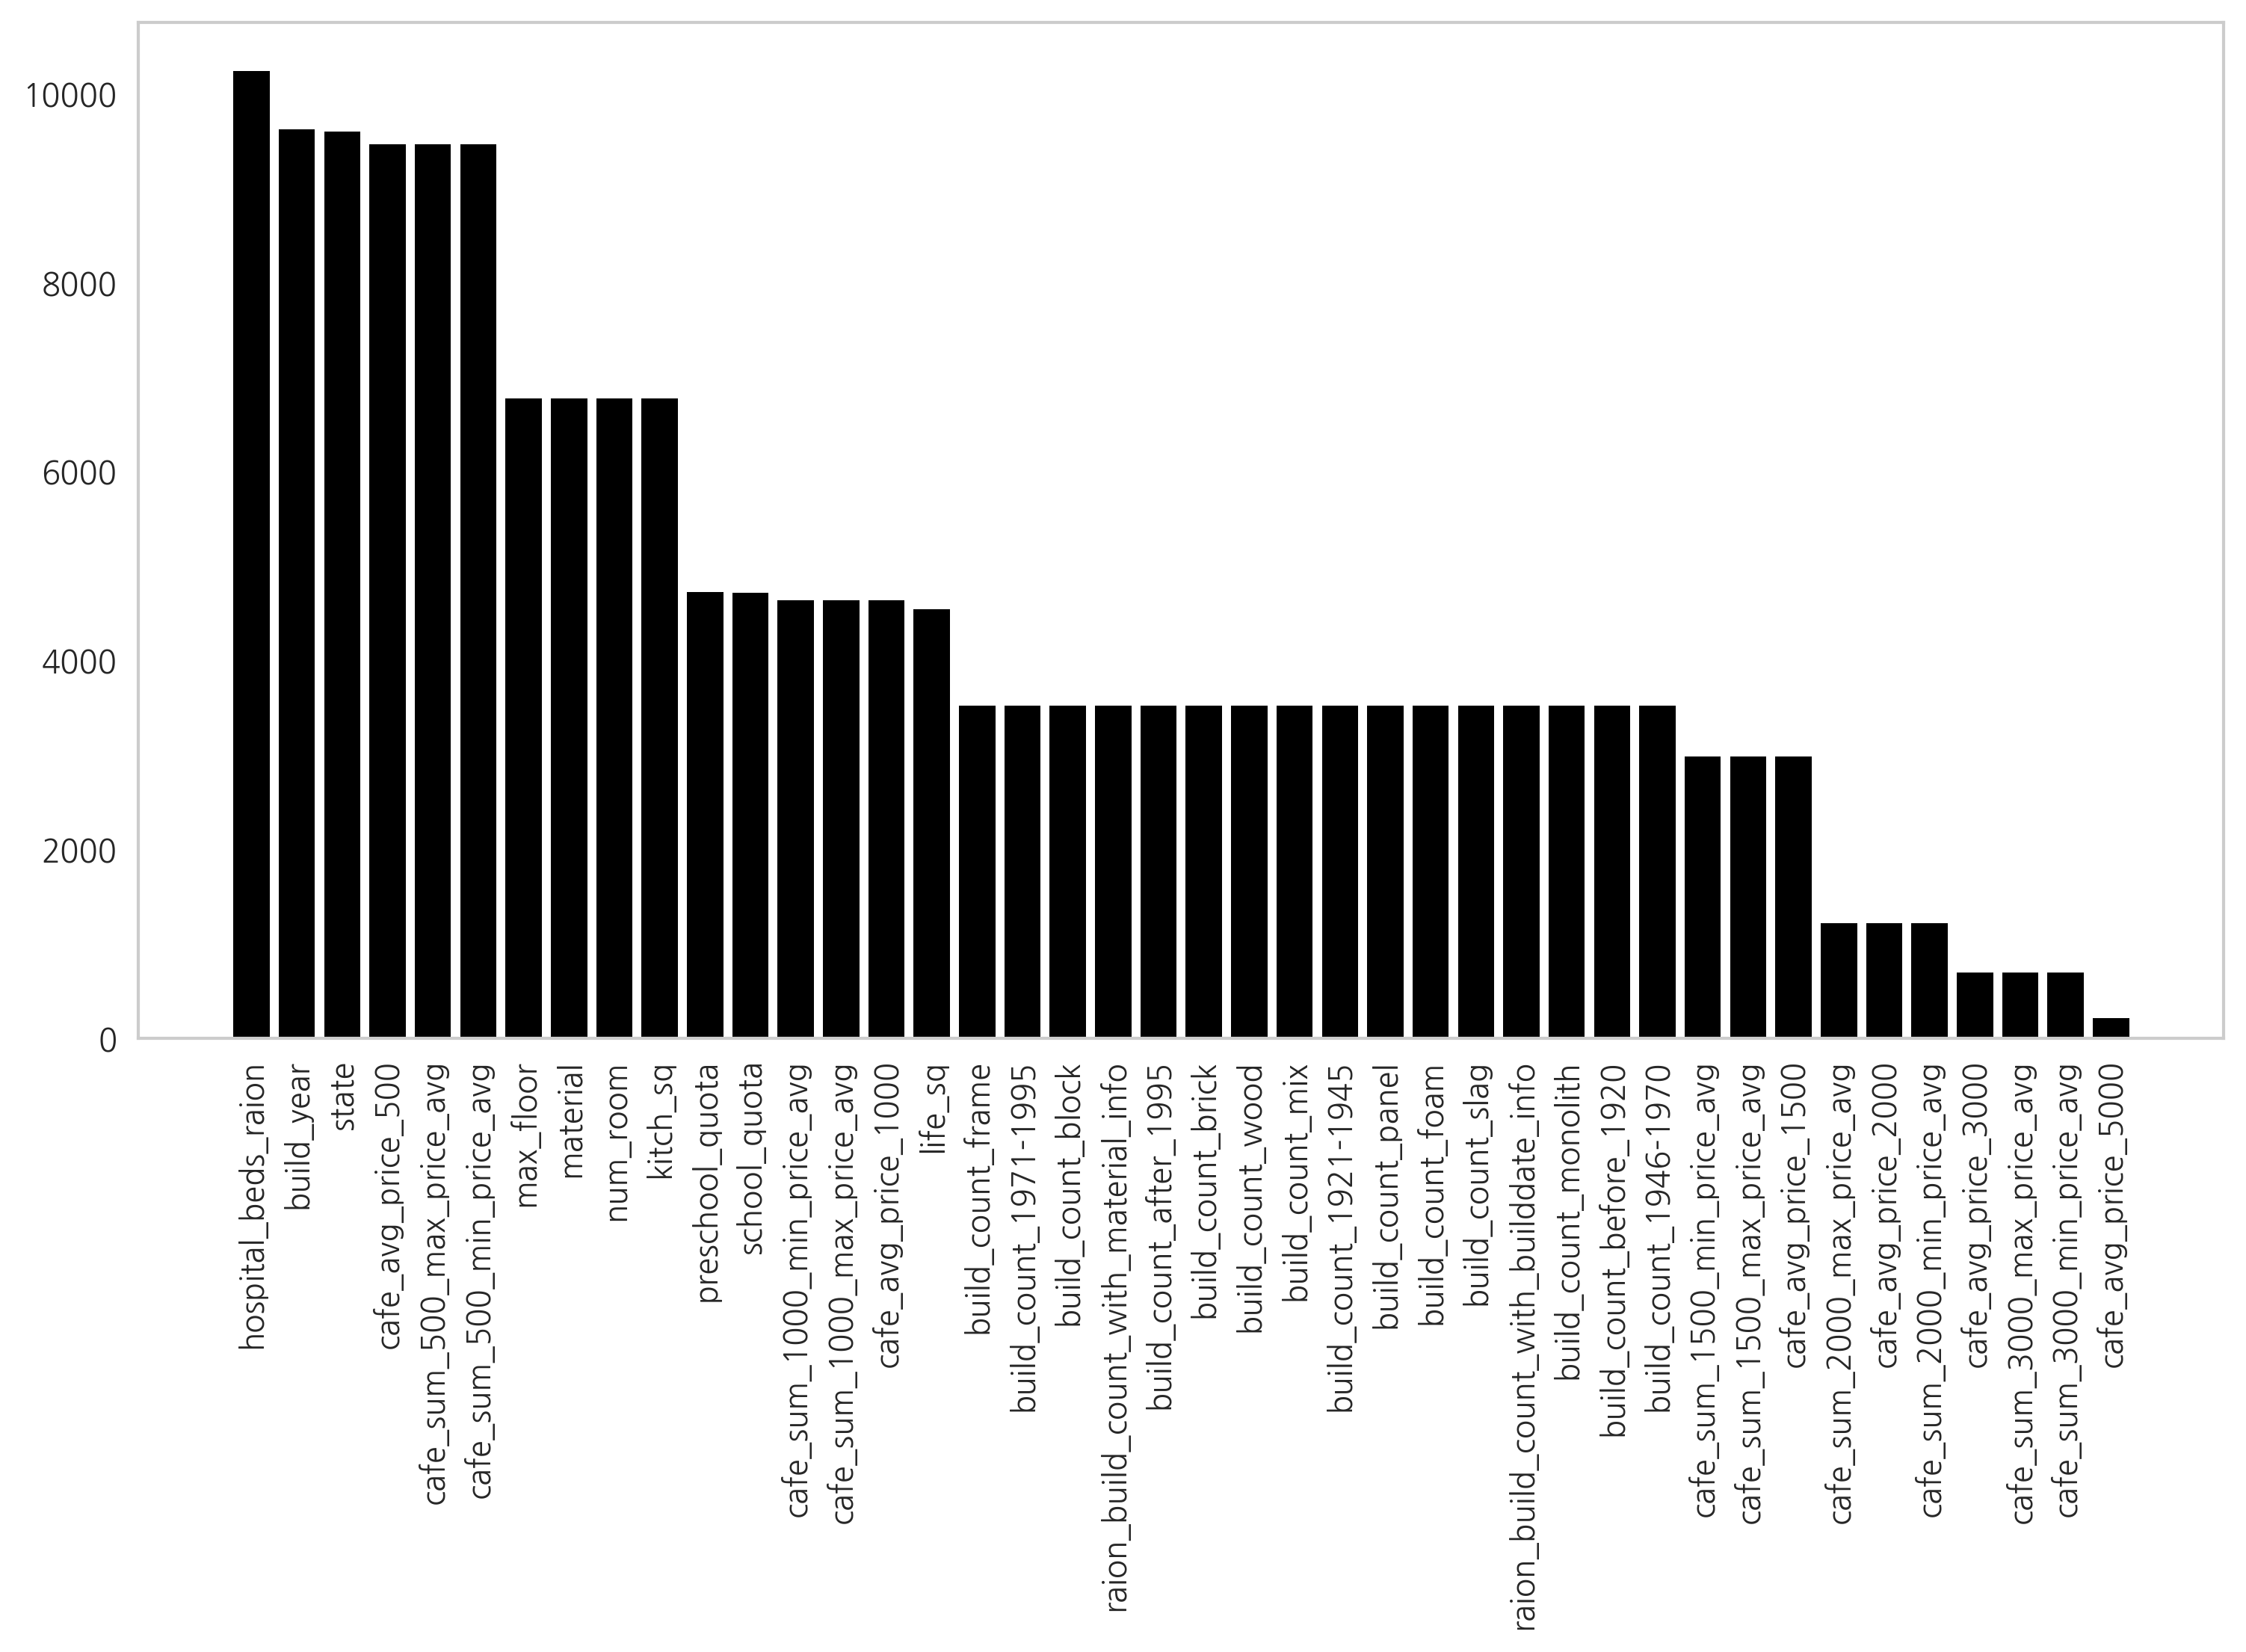

In [41]:
height = train_raw.isnull().sum().sort_values(ascending=False).values[:42]
bars = train_raw.isnull().sum().sort_values(ascending=False).index[:42]
y_nan = np.arange(len(bars))

plt.figure(figsize=(12,6))
# Create bars
plt.bar(y_nan, height, color='black') 
# Create names on the x-axis
plt.xticks(y_nan, bars, rotation='vertical', fontsize=10)
plt.yticks(fontsize=10)
# Show graphic
plt.grid(False)
plt.show()

### price_doc - timestamp

In [45]:
timeseries = train_raw[['price_doc', 'timestamp']]
timeseries = timeseries.set_index(['timestamp'])
read_timeseries = timeseries.groupby(lambda month : month[:7]).mean()

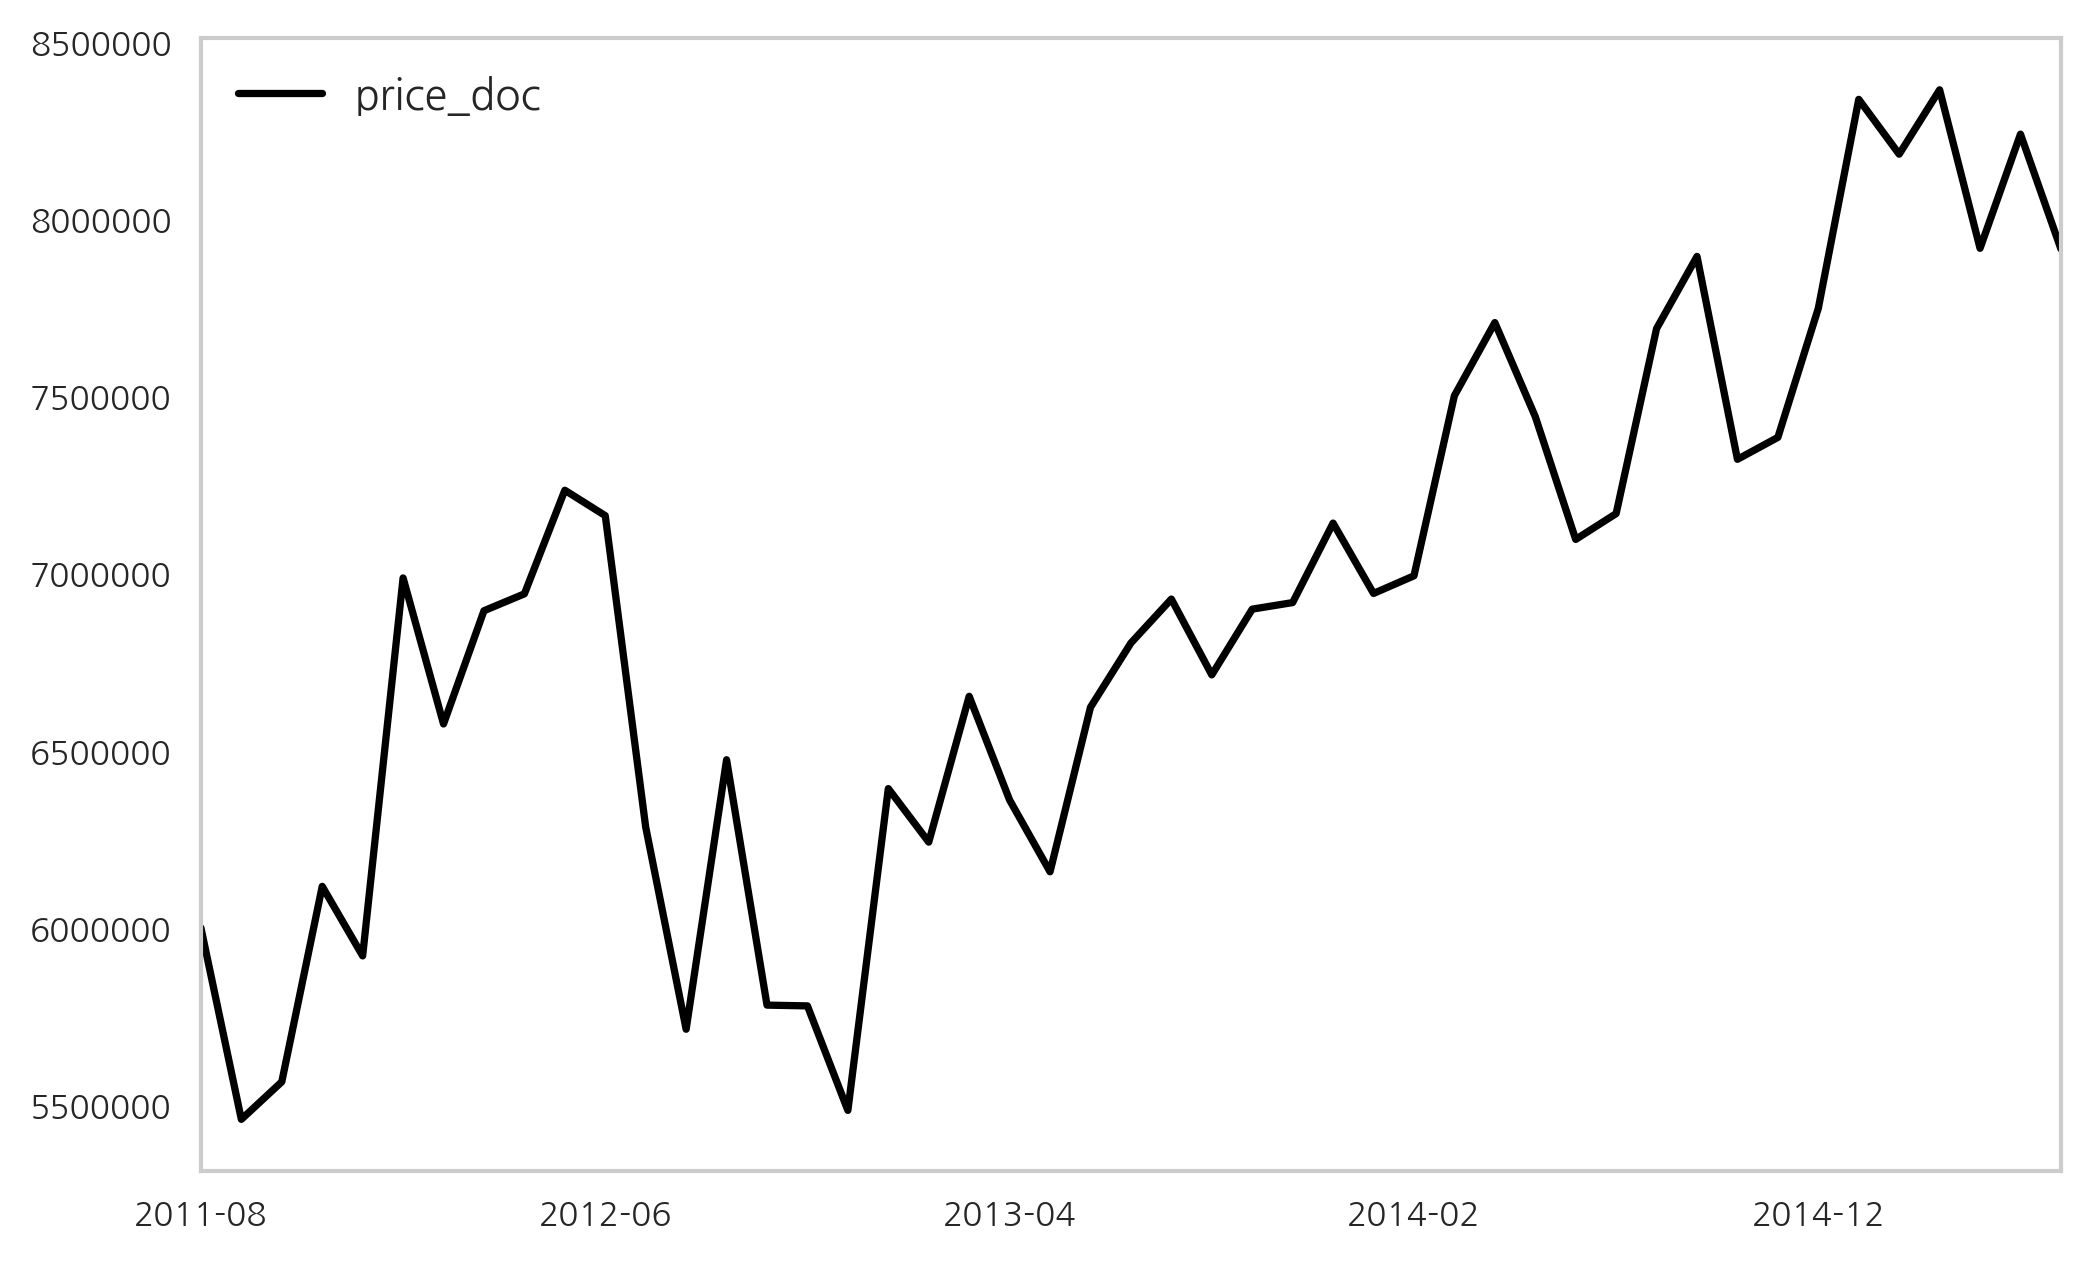

In [47]:
plt.figure(figsize=(12,6))
read_timeseries.plot(fontsize=8, color='black')
plt.grid(False)

### Category - Histogram

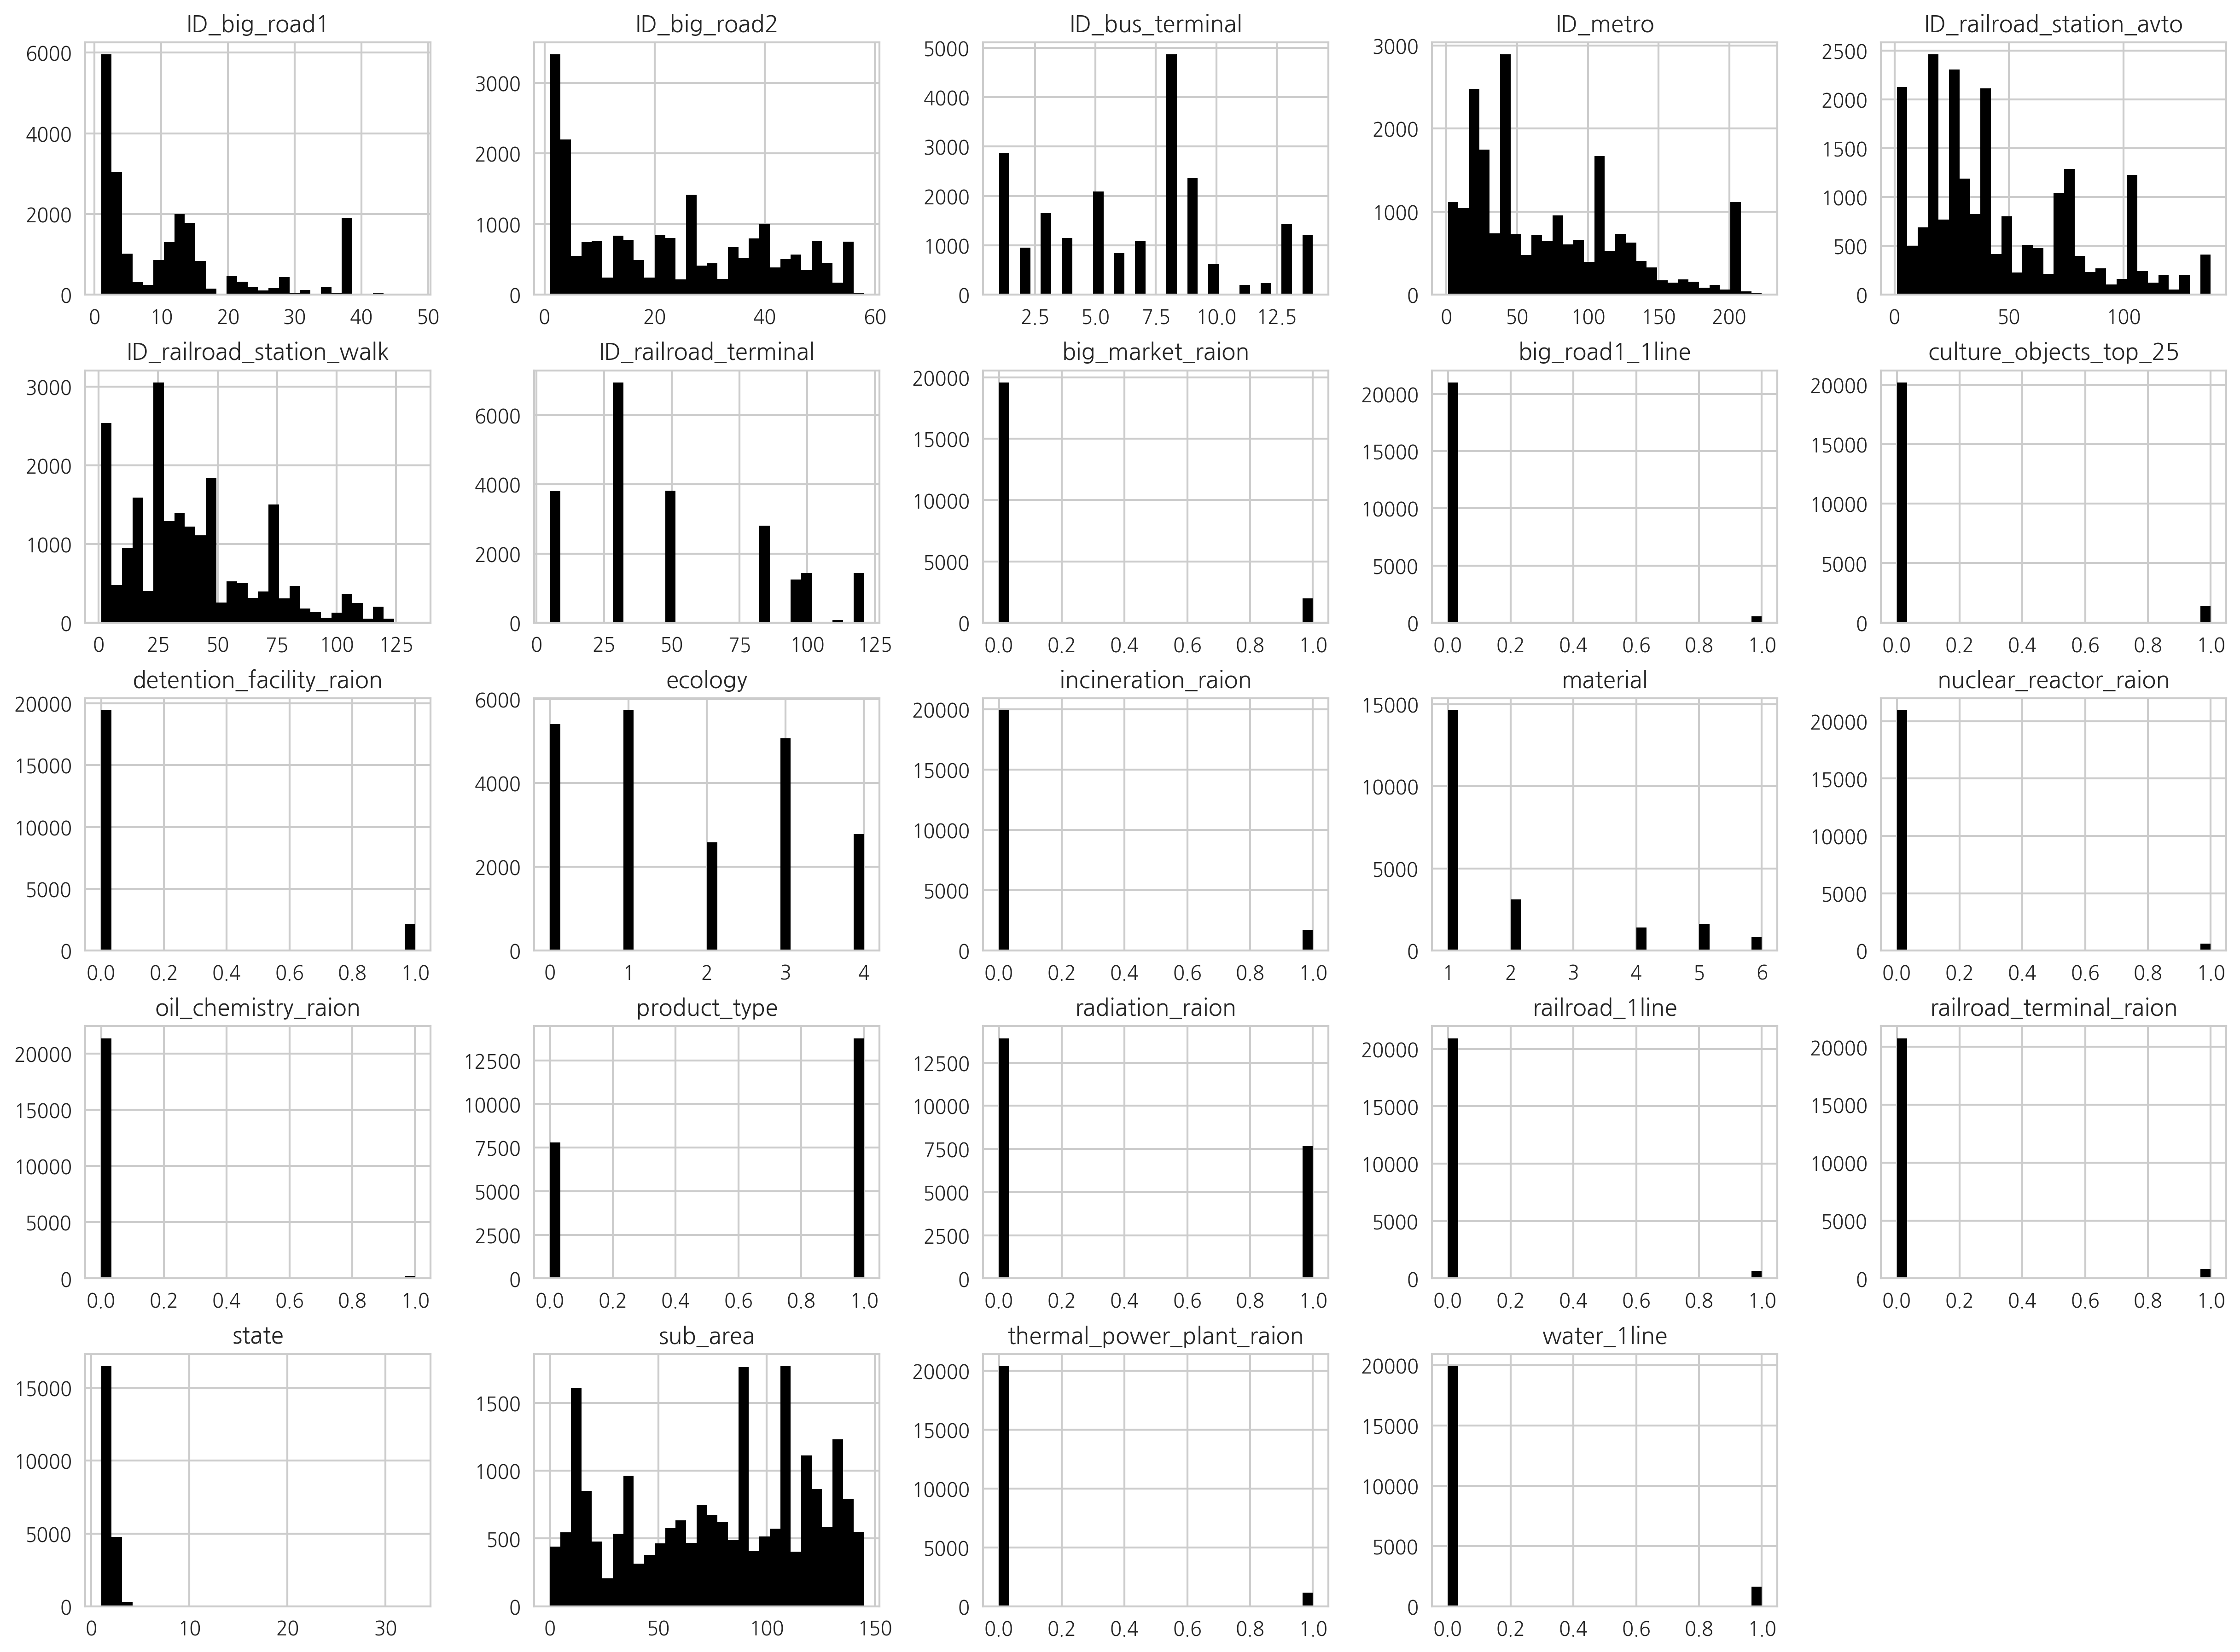

In [48]:
cat_df_for_plot.hist(bins=30, figsize=(20,15), color='black')
plt.show()

### Category - Barplot

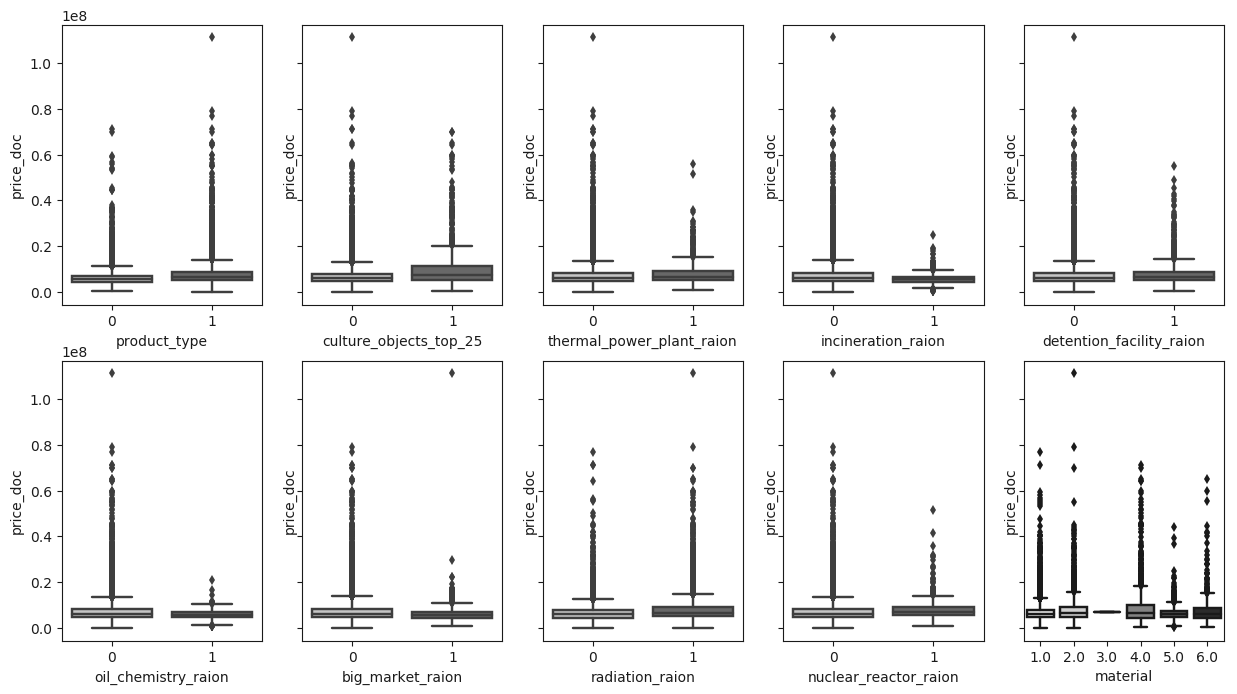

In [49]:
catplot_list = cat_df_for_plot.columns
with plt.style.context(('default')):
    f, axes = plt.subplots(2, 5, figsize=(15, 8), sharey=True)    
     
for num, ax in zip(range(10), axes.flat):
    try:
        sns.boxplot(x=cat_df_for_plot[catplot_list[num]], y=y_df, palette='Greys', ax=ax)
    except:
        pass

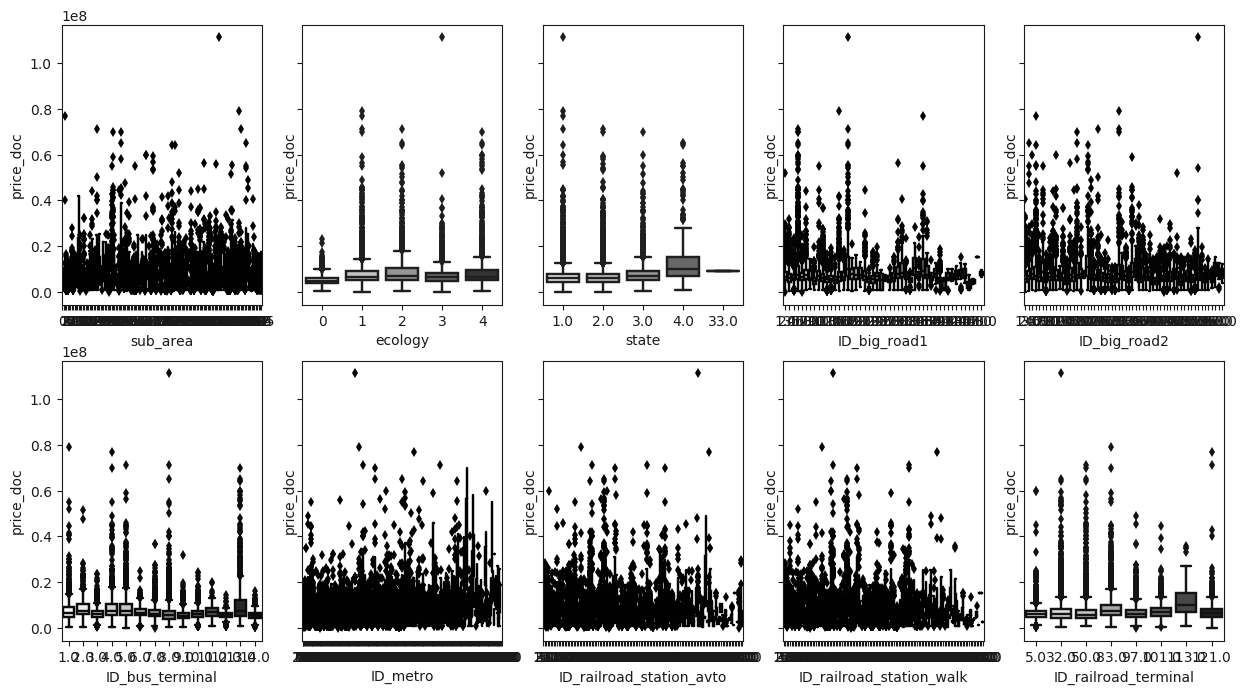

In [50]:
with plt.style.context(('default')):
    f, axes = plt.subplots(2, 5, figsize=(15, 8), sharey=True)    
     
for num, ax in zip(range(10, 20), axes.flat):
    try:
        sns.boxplot(x=cat_df_for_plot[catplot_list[num]], y=y_df, palette='Greys', ax=ax)
    except:
        pass

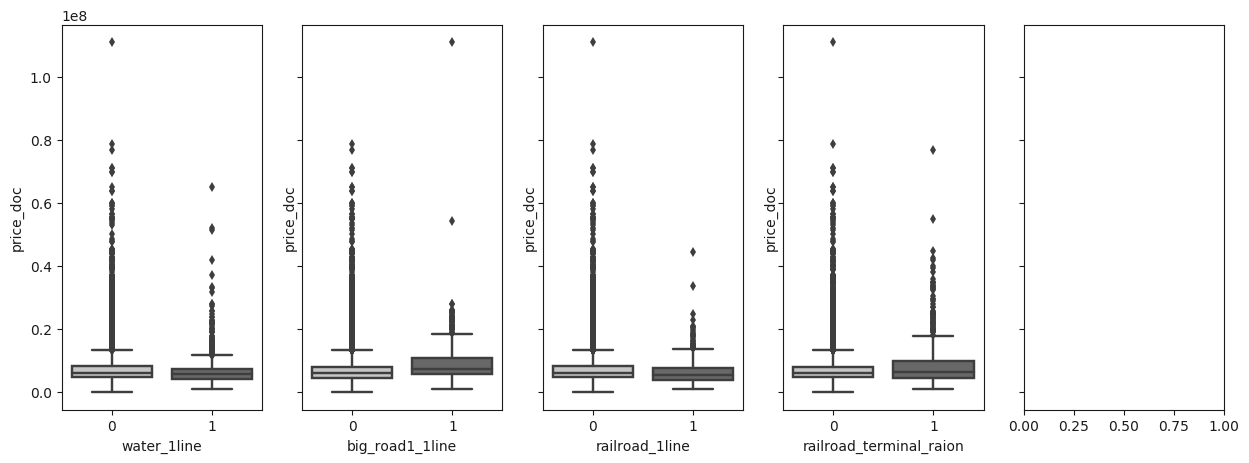

In [51]:
with plt.style.context(('default')):
    f, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)    
     
for num, ax in zip(range(20, 25), axes.flat):
    try:
        sns.boxplot(x=cat_df_for_plot[catplot_list[num]], y=y_df, palette='Greys', ax=ax)
    except:
        pass

### Numeric : price_doc - full_sq

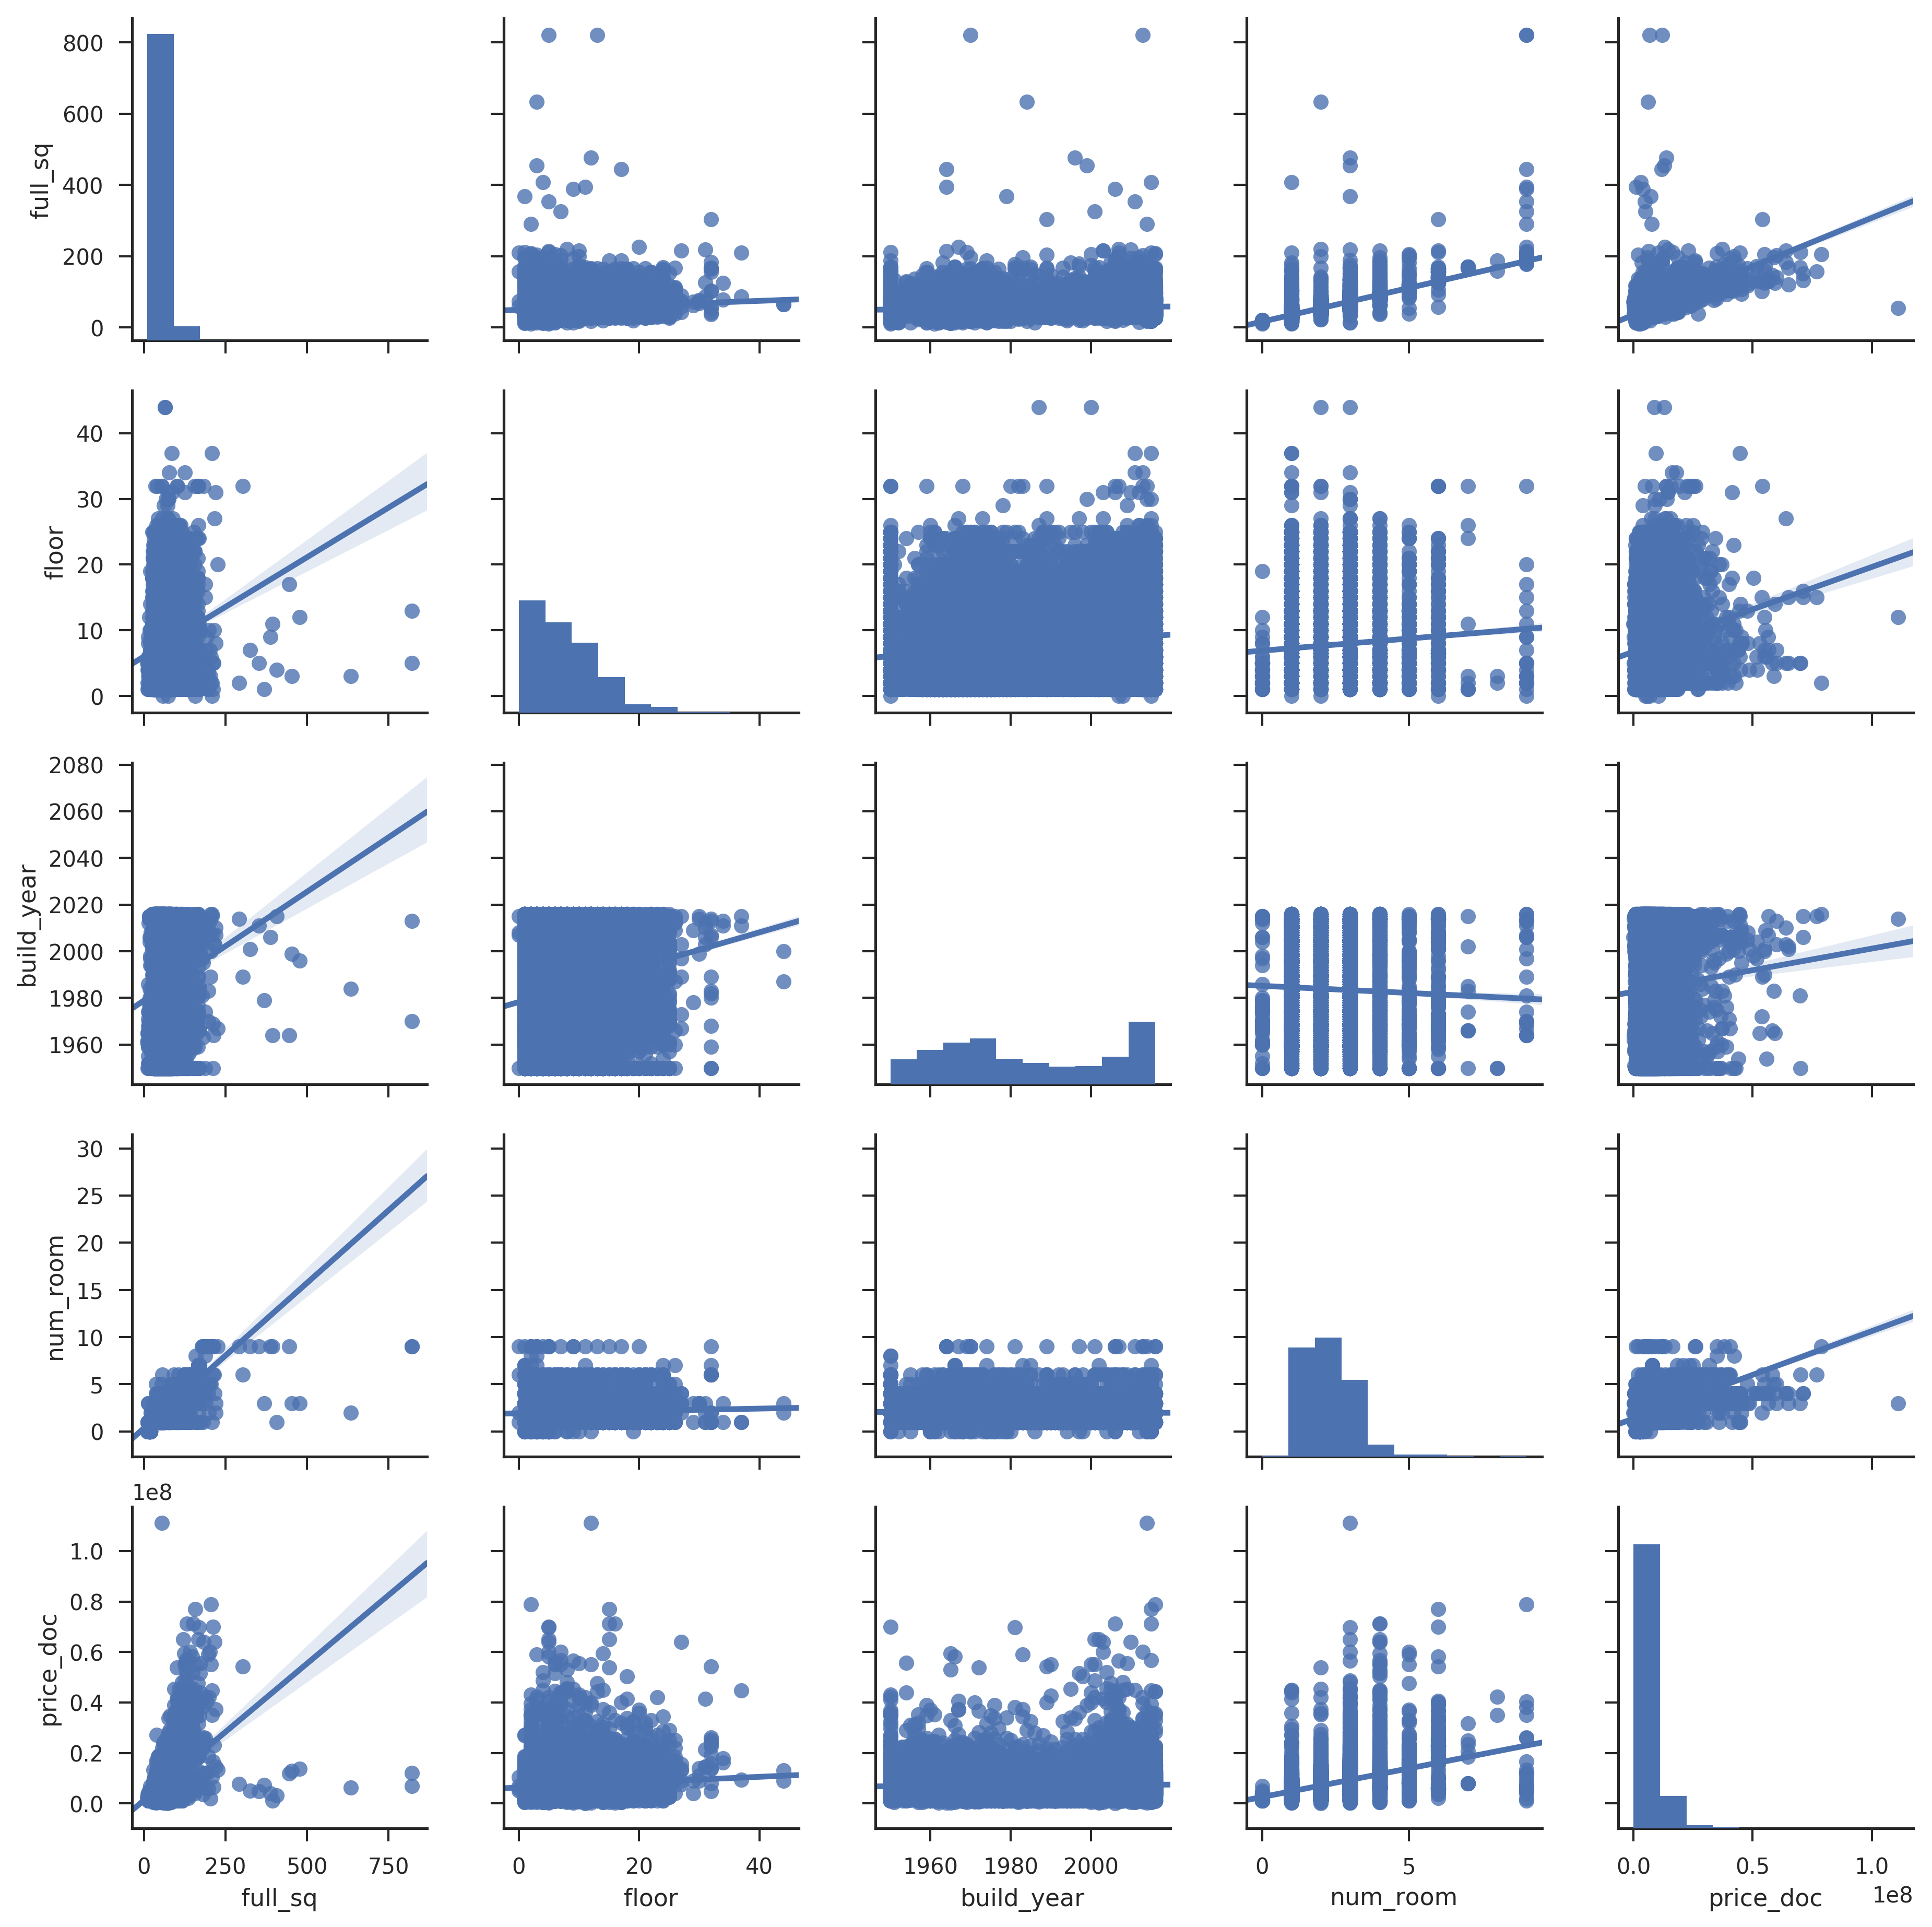

In [53]:
cols = ["full_sq", "floor", "build_year", "num_room", "price_doc"]
sns.set(style="ticks")
g = sns.pairplot(train_df_p[cols], kind="reg")

#   
# 2. Feature Selection
- 2.1 Neighbourhood & Macro Features Selection with Loop
- 2.2 R-Style formulation & Optimization

##        
## 2.1 Neighbourhood & Macro Features Selection with Loop
- 2.1.1 Numeric Variable Selection
- 2.1.2 Categorical Variable Selection

## 2.1.1 Numeric Variable Selection (With Loop)
- Forward and Backward loop

### Forward Selection - Serial Loop
- X : numeric train & macro variables
- Y : log y

In [24]:
model_s1, result_s1, x_s1, y_s1 = auto_eli_and_result_print(num_dum_df_do1, y_df_log_do1, modeltype=0, ser_1=0.000001, ser_2=0.5, ser_3=0.0000001)

In [25]:
print(result_s1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     291.2
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        19:20:44   Log-Likelihood:                -10705.
No. Observations:               20579   AIC:                         2.152e+04
Df Residuals:                   20522   BIC:                         2.198e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [26]:
result_s1.params.index

Index(['const', 'full_sq', 'num_room', 'product_type', 'kitch_sq', 'max_floor',
       'real_dispos_income_per_cap_growth',
       'load_of_teachers_preschool_per_teacher', 'build_year',
       'apartment_fund_sqm', 'marriages_per_1000_cap', 'labor_force',
       'heating_share', 'oil_chemistry_km', '0_17_male', 'exhibition_km',
       'railroad_station_avto_min', 'build_count_monolith', 'sadovoe_km',
       'culture_objects_top_25', 'cafe_count_5000_price_2500',
       'culture_objects_top_25_raion', 'big_road1_km', 'radiation_raion',
       'indust_part', 'detention_facility_raion', 'leisure_count_500',
       'mosque_count_1500', 'hospital_beds_raion', 'big_road1_1line',
       'mosque_count_5000', 'build_count_frame', 'church_synagogue_km',
       'green_zone_km', 'cafe_sum_5000_min_price_avg', 'young_female',
       'healthcare_centers_raion', 'green_part_3000', 'industrial_km',
       'prom_part_3000', 'cafe_avg_price_2000', 'cafe_sum_1000_max_price_avg',
       'cafe_avg_price_5

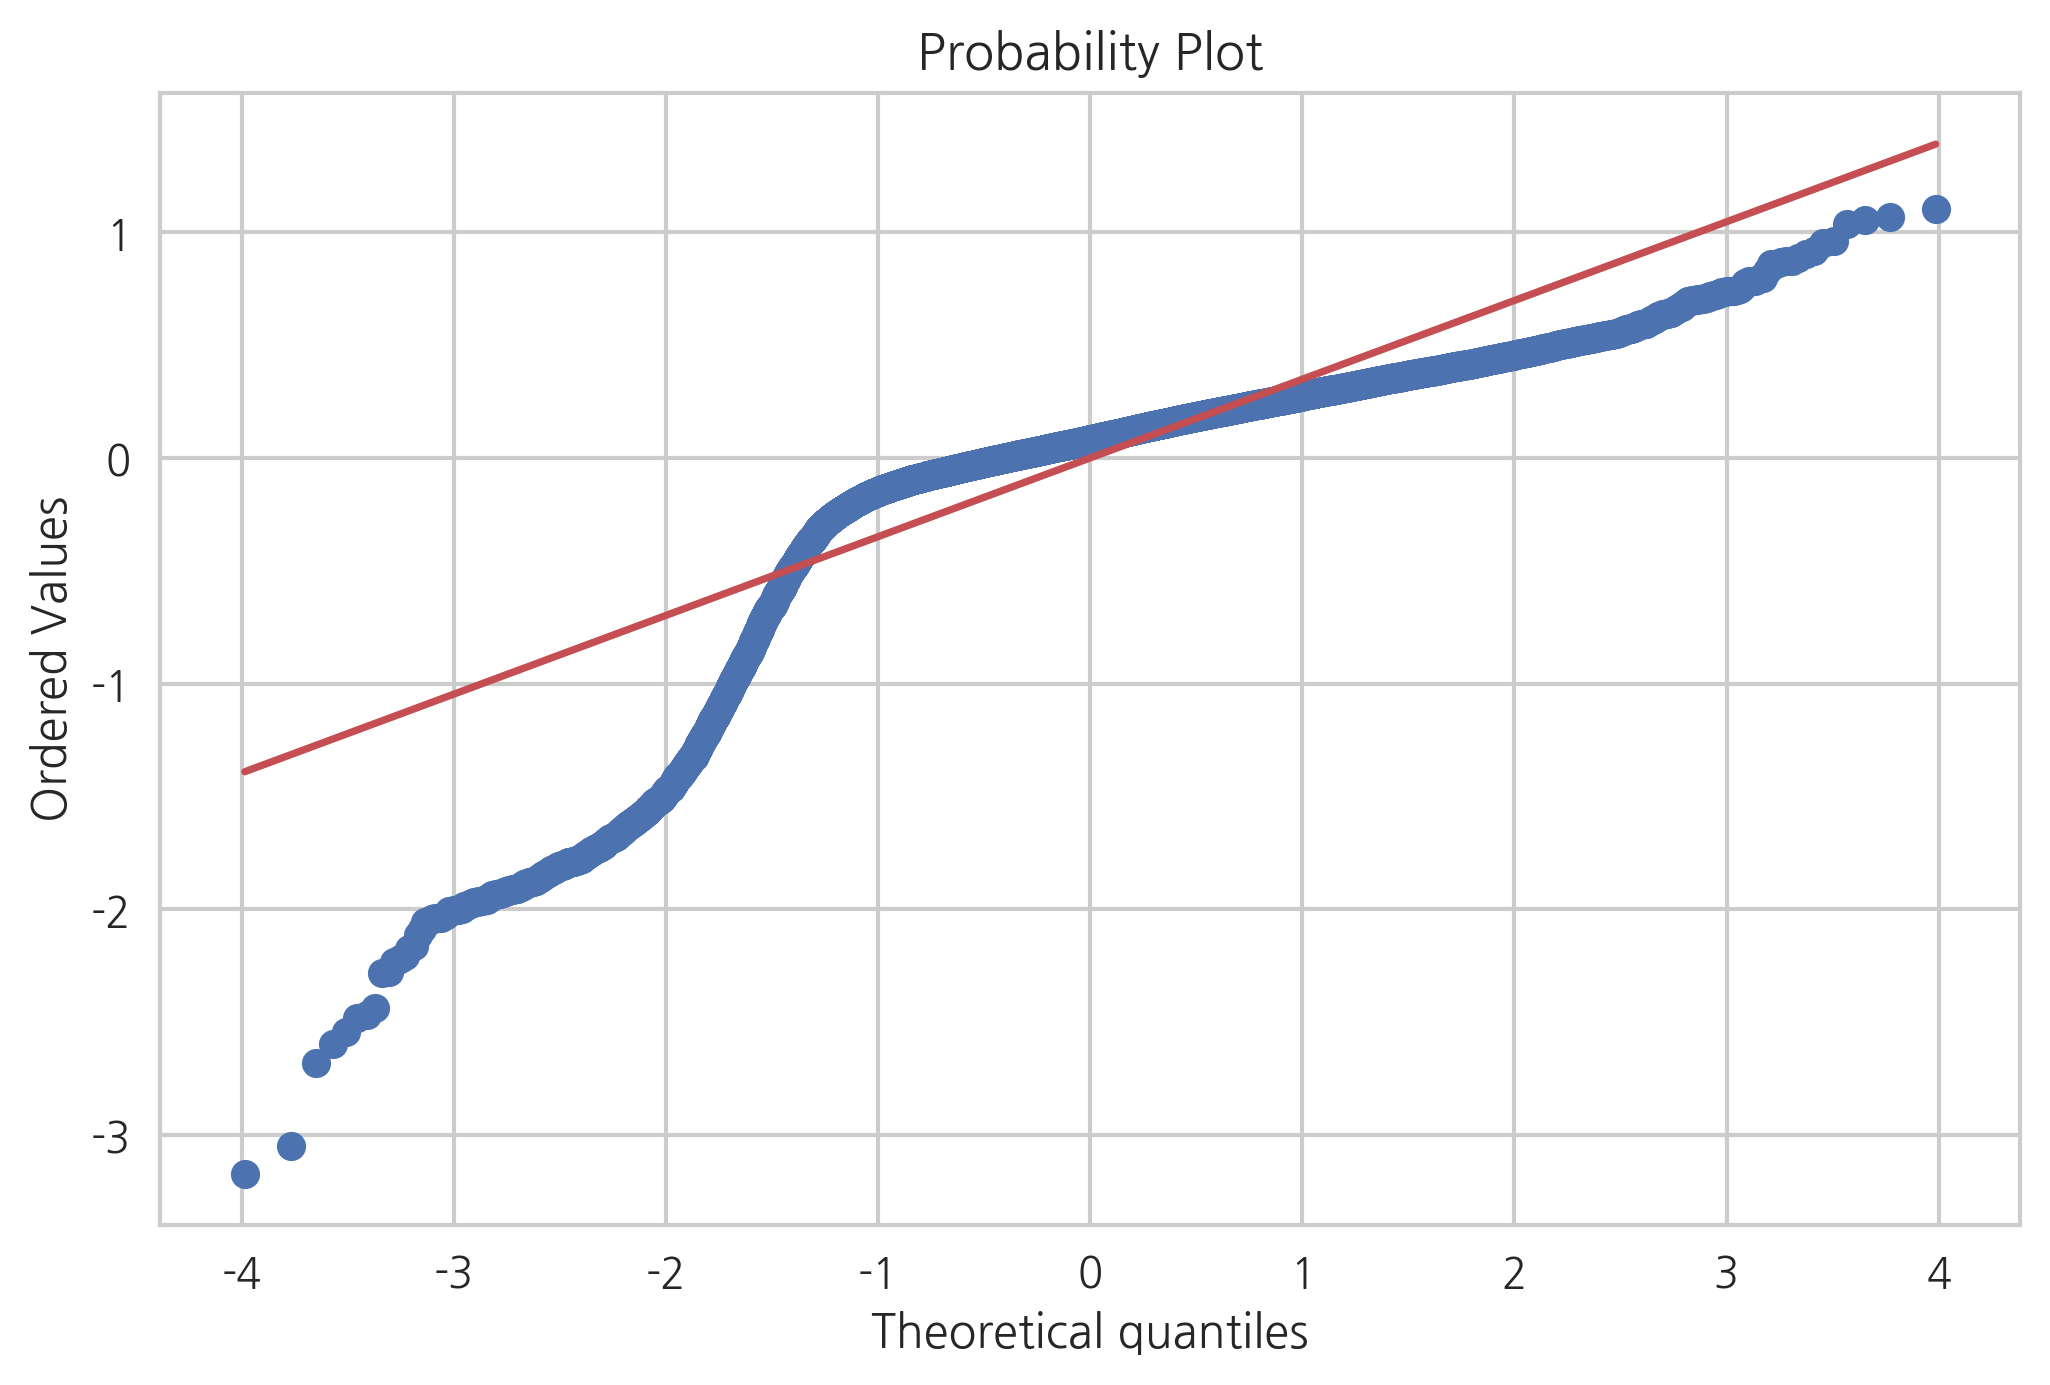

In [27]:
sp.stats.probplot(result_s1.resid, plot=plt)
plt.show()

> 2nd Serial : 로그 Y 보다 안정적인 수치를 보임.

In [28]:
model_s2, result_s2, x_s2, y_s2 = serial_eli_lim_pval(num_dum_df_do1, y_df_do1, ser_1=0.000001, ser_2=0.5, ser_3=0.0000001)

In [29]:
print(result_s2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     628.0
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        19:24:12   Log-Likelihood:            -3.2790e+05
No. Observations:               20579   AIC:                         6.559e+05
Df Residuals:                   20517   BIC:                         6.564e+05
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

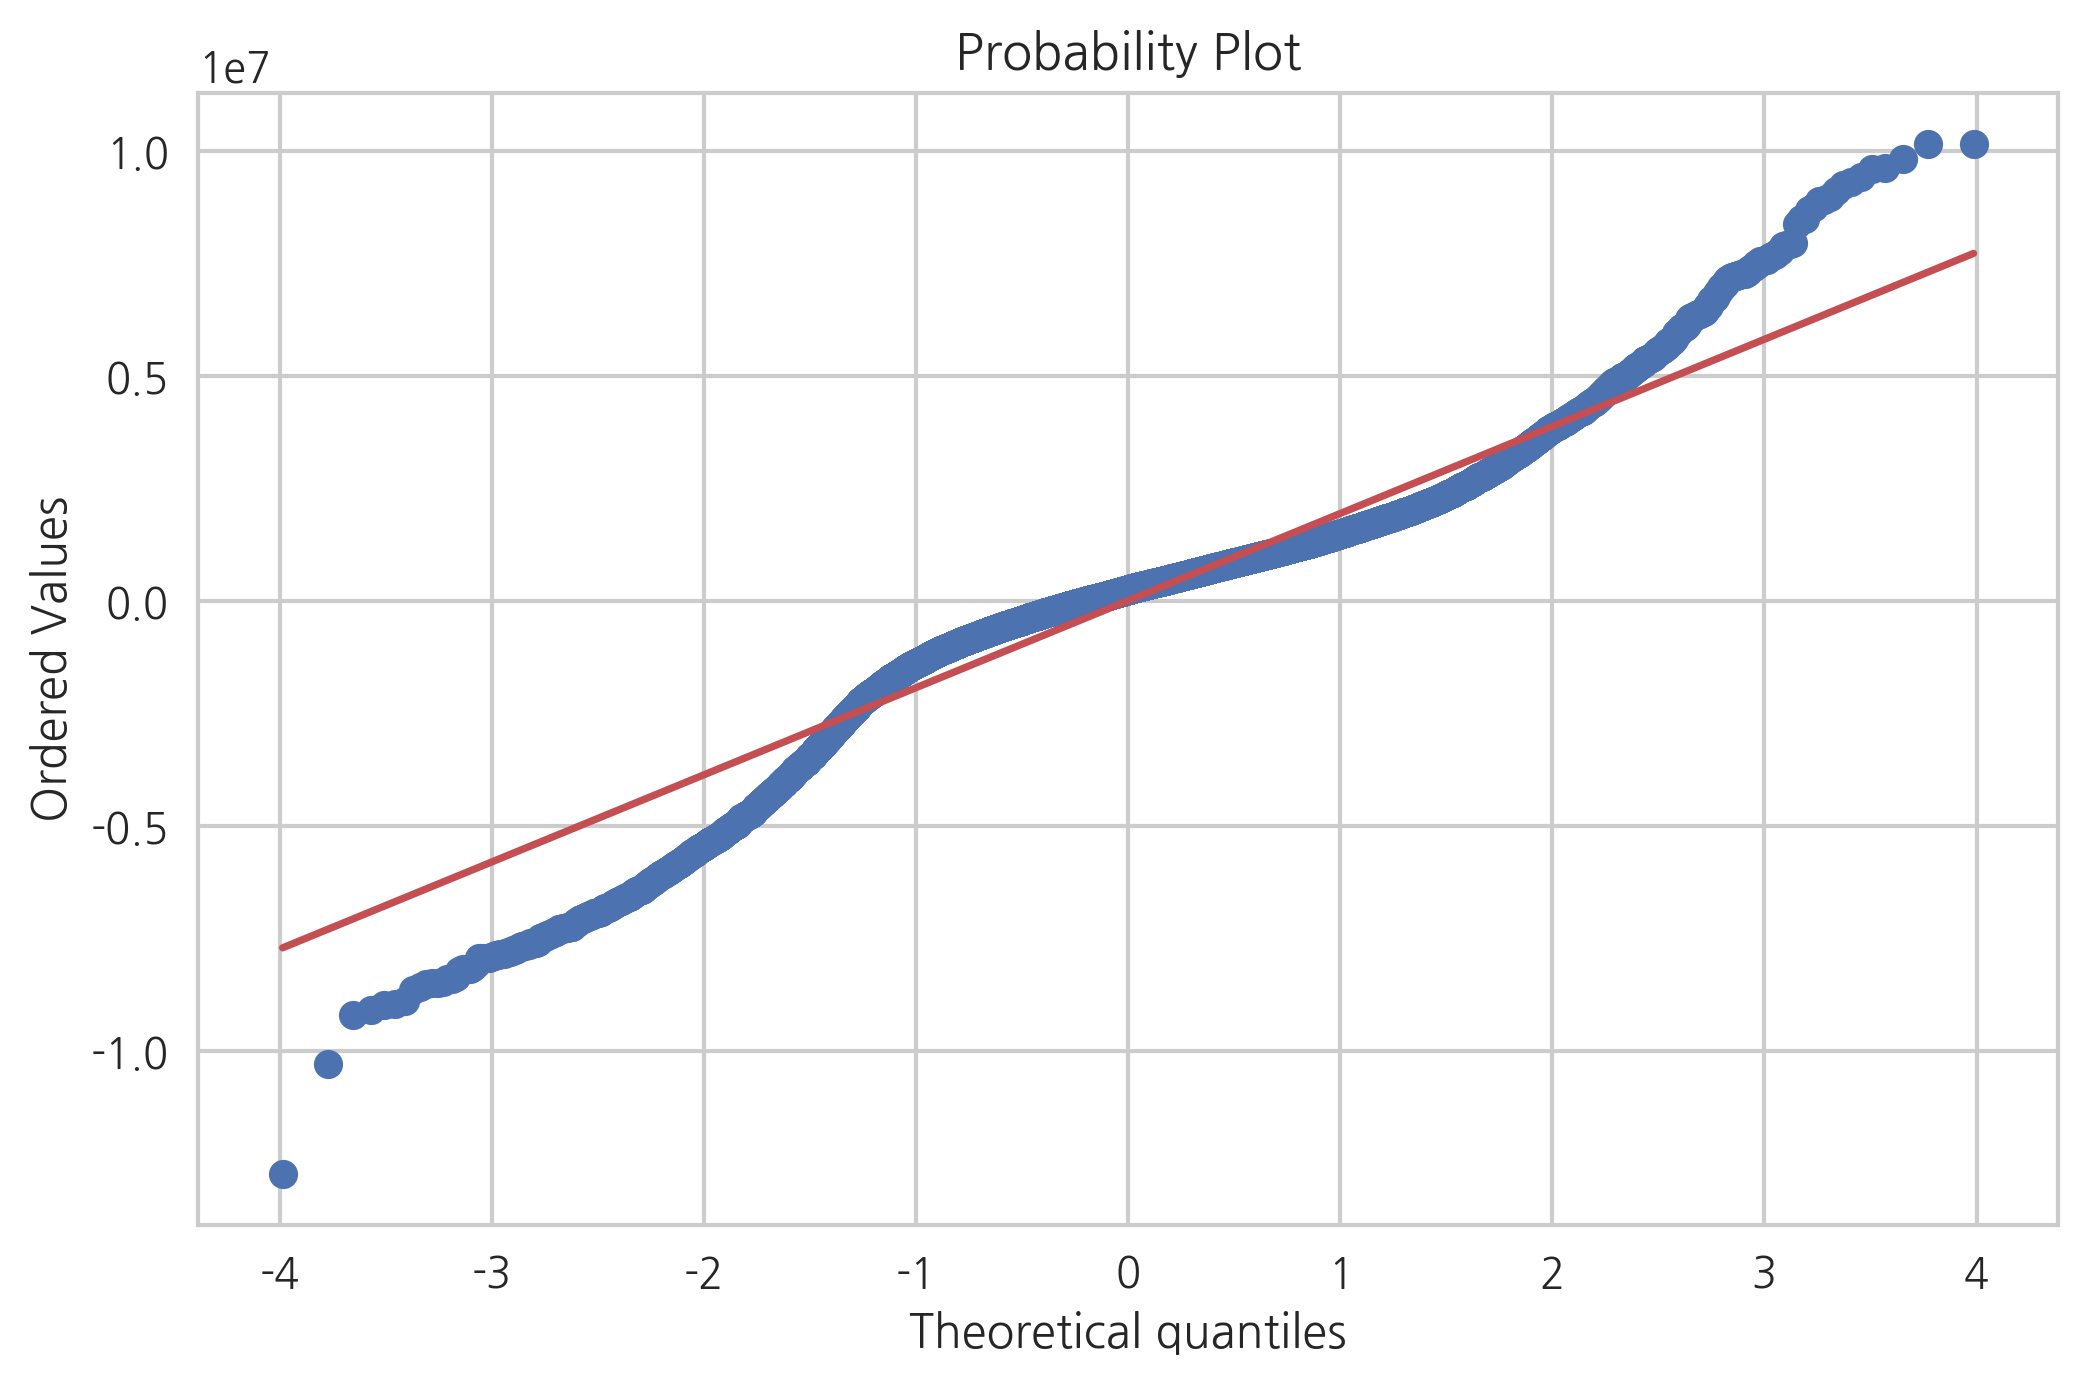

In [30]:
sp.stats.probplot(result_s2.resid, plot=plt)
plt.show()

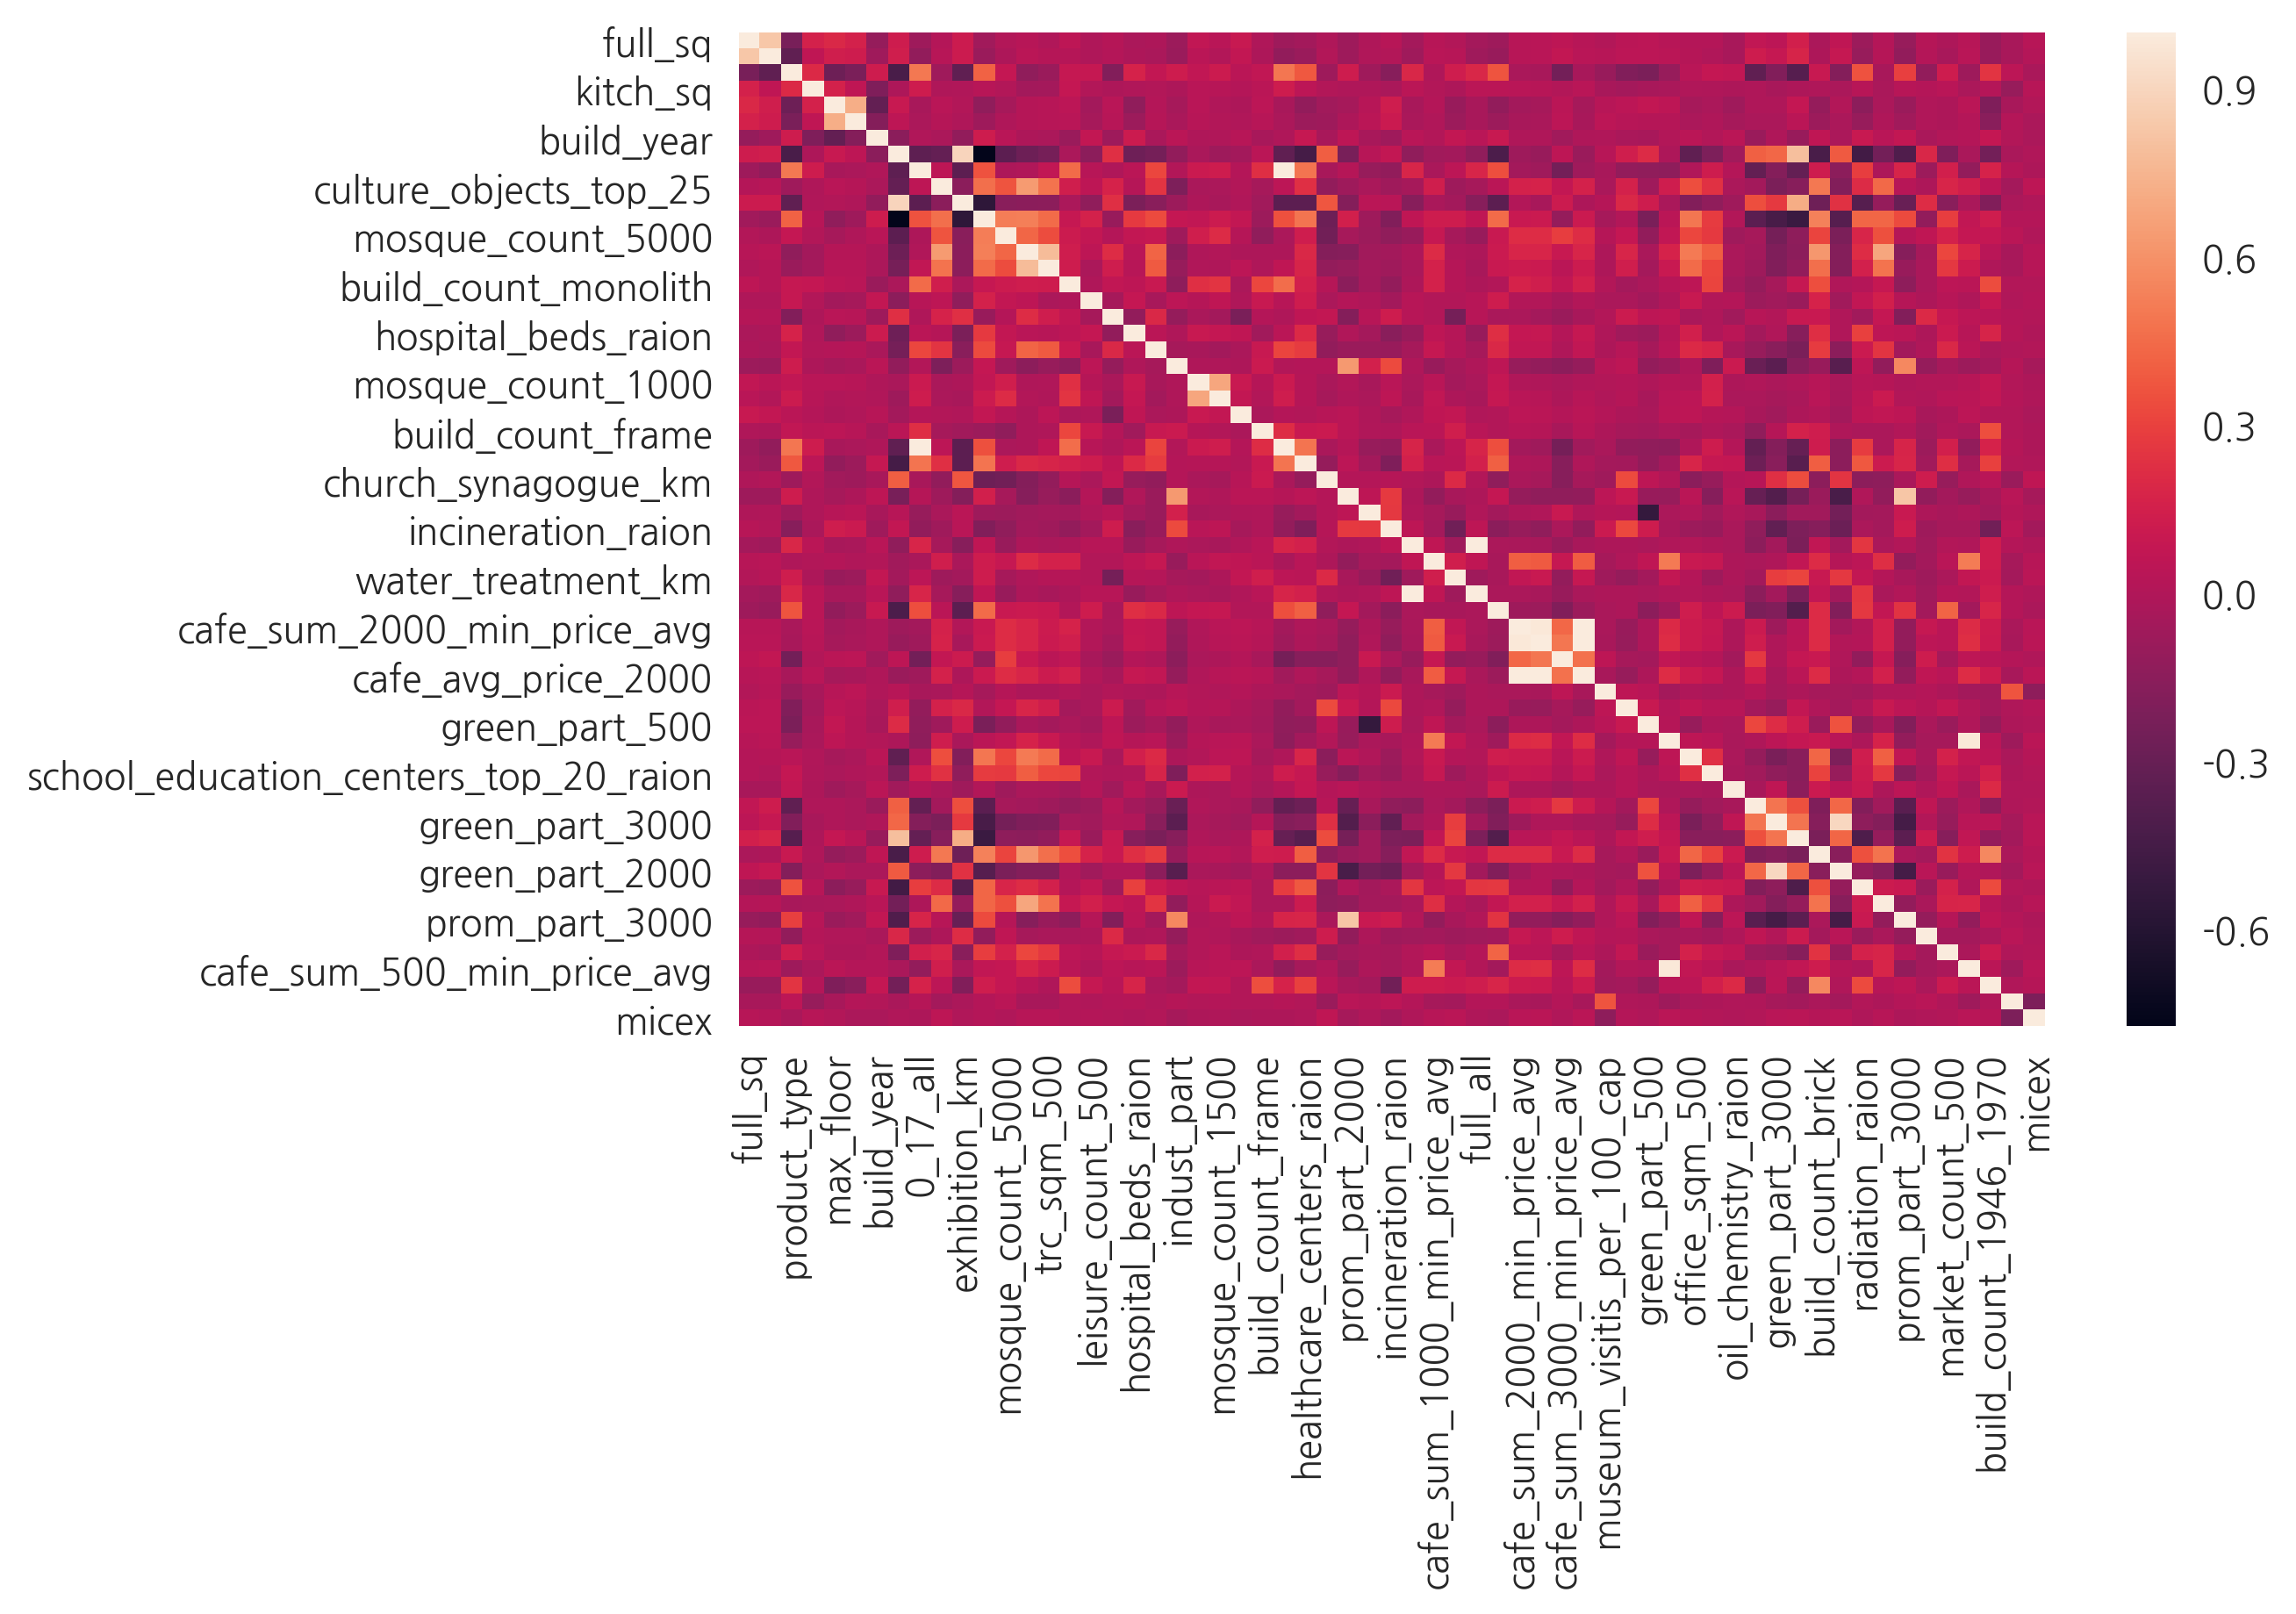

In [31]:
be_temp_df = num_dum_df_do1[result_s2.params.index[1:]]
sns.heatmap(be_temp_df.corr())
plt.show()

> 3nd : serial

In [40]:
new_params_s2 = result_s2.pvalues[result_s2.pvalues.values < 0.10].index[1:]
new_params_s2

Index(['full_sq', 'life_sq', 'product_type', 'kitch_sq', 'max_floor', 'floor',
       'build_year', 'sadovoe_km', '0_17_all', 'culture_objects_top_25',
       'exhibition_km', 'trc_count_5000', 'cafe_count_1500_price_4000',
       'trc_sqm_500', 'build_count_monolith', 'leisure_count_500',
       'big_road1_km', 'detention_facility_raion', 'indust_part',
       'mosque_count_1000', 'big_road1_1line', 'build_count_frame',
       '0_17_male', 'healthcare_centers_raion', 'church_synagogue_km',
       'prom_part_2000', 'green_zone_km', 'incineration_raion',
       'cafe_sum_1000_min_price_avg', 'water_treatment_km',
       'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
       'cafe_sum_3000_min_price_avg', 'cafe_avg_price_2000',
       'museum_visitis_per_100_cap', 'cemetery_km', 'office_sqm_500',
       'school_education_centers_top_20_raion', 'oil_chemistry_raion',
       'railroad_station_avto_min', 'green_part_3000', 'oil_chemistry_km',
       'green_part_2000', 'radiati

In [6]:
new_params_s2 = ['full_sq', 'life_sq', 'product_type', 'kitch_sq', 'max_floor', 'floor',
       'build_year', 'sadovoe_km', '0_17_all', 'culture_objects_top_25',
       'exhibition_km', 'trc_count_5000', 'cafe_count_1500_price_4000',
       'trc_sqm_500', 'build_count_monolith', 'leisure_count_500',
       'big_road1_km', 'detention_facility_raion', 'indust_part',
       'mosque_count_1000', 'big_road1_1line', 'build_count_frame',
       '0_17_male', 'healthcare_centers_raion', 'church_synagogue_km',
       'prom_part_2000', 'green_zone_km', 'incineration_raion',
       'cafe_sum_1000_min_price_avg', 'water_treatment_km',
       'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
       'cafe_sum_3000_min_price_avg', 'cafe_avg_price_2000',
       'museum_visitis_per_100_cap', 'cemetery_km', 'office_sqm_500',
       'school_education_centers_top_20_raion', 'oil_chemistry_raion',
       'railroad_station_avto_min', 'green_part_3000', 'oil_chemistry_km',
       'green_part_2000', 'radiation_raion', 'cafe_count_1000_price_high',
       'prom_part_3000', 'build_count_1946_1970', 'rts', 'micex']

result_s3 = sm.OLS(y_df_do1, num_dum_df_do1[new_params_s2]).fit()

In [7]:
print(result_s3.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     5595.
Date:                Wed, 03 Jan 2018   Prob (F-statistic):               0.00
Time:                        22:36:07   Log-Likelihood:            -3.2792e+05
No. Observations:               20579   AIC:                         6.559e+05
Df Residuals:                   20530   BIC:                         6.563e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [56]:
result_s3.params.index

Index(['full_sq', 'life_sq', 'product_type', 'kitch_sq', 'max_floor', 'floor',
       'build_year', 'sadovoe_km', '0_17_all', 'culture_objects_top_25',
       'exhibition_km', 'trc_count_5000', 'cafe_count_1500_price_4000',
       'trc_sqm_500', 'build_count_monolith', 'leisure_count_500',
       'big_road1_km', 'detention_facility_raion', 'indust_part',
       'mosque_count_1000', 'big_road1_1line', 'build_count_frame',
       '0_17_male', 'healthcare_centers_raion', 'church_synagogue_km',
       'prom_part_2000', 'green_zone_km', 'incineration_raion',
       'cafe_sum_1000_min_price_avg', 'water_treatment_km',
       'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
       'cafe_sum_3000_min_price_avg', 'cafe_avg_price_2000',
       'museum_visitis_per_100_cap', 'cemetery_km', 'office_sqm_500',
       'school_education_centers_top_20_raion', 'oil_chemistry_raion',
       'railroad_station_avto_min', 'green_part_3000', 'oil_chemistry_km',
       'green_part_2000', 'radiati

### Backward Elimination
- 높은 공산성 수치를 보임

In [44]:
model_b1, result_b1, x_b1, y_b1 = auto_eli_and_result_print(num_dum_df_do1, y_df_do1, modeltype = 1, lim_=0.000001)

In [45]:
print(result_b1.summary()) 

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     652.3
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        19:36:07   Log-Likelihood:            -3.2689e+05
No. Observations:               20579   AIC:                         6.539e+05
Df Residuals:                   20510   BIC:                         6.545e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


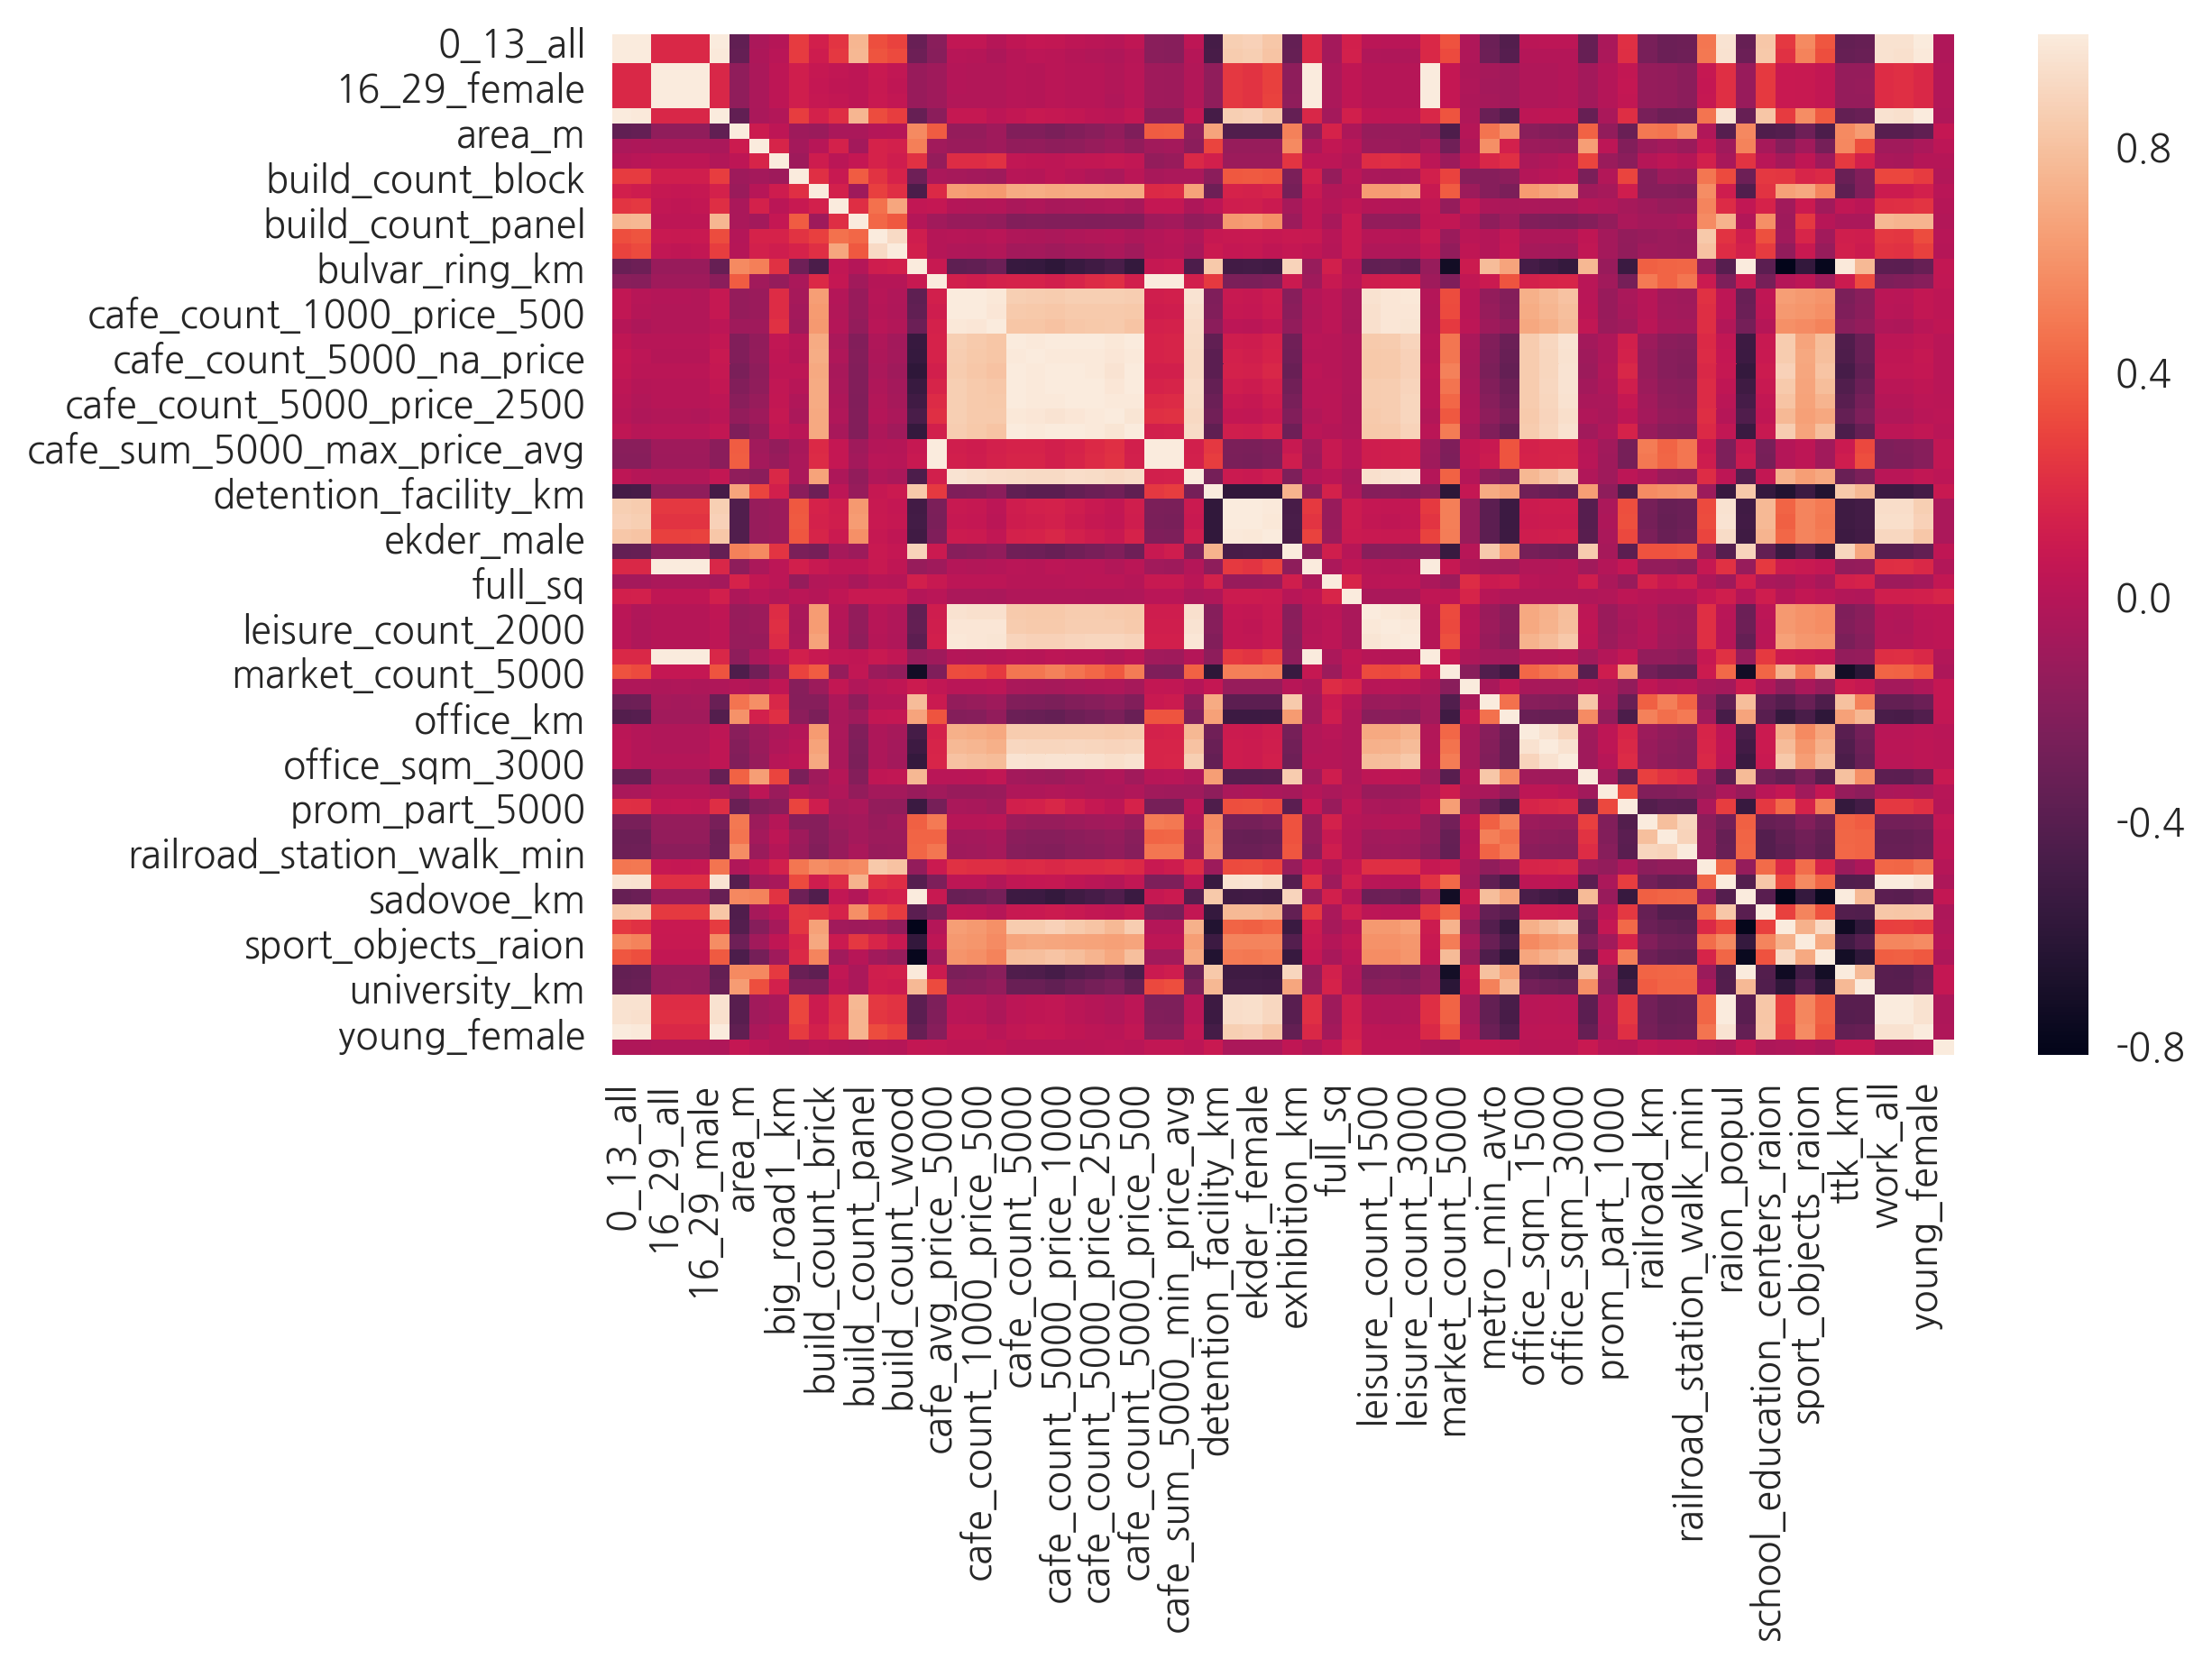

In [46]:
be_temp_df = num_dum_df_do1[result_b1.params.index[1:]]
sns.heatmap(be_temp_df.corr())
plt.show()

> Filtering by VIF val to remove multi-corlinearity

In [47]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(num_dum_df_do1[result_b1.params.index[1:]].values, i) \
                     for i in range(num_dum_df_do1[result_b1.params.index[1:]].shape[1])]
vif["features"] = num_dum_df_do1[result_b1.params.index[1:]].columns
vif.head(n=20)

VIF Factor                    features
0   8.283391e+04                    0_13_all
1   5.130880e+04                    0_6_male
2   2.351197e+11                   16_29_all
3   6.224611e+10                16_29_female
4   5.549517e+10                  16_29_male
5   5.531346e+04                   7_14_male
6   9.488927e+00                      area_m
7   1.996832e+01               big_market_km
8   7.408742e+00                big_road1_km
9   6.437928e+01           build_count_block
10  3.051745e+02           build_count_brick
11  9.941949e+00           build_count_frame
12  3.656209e+02           build_count_panel
13  2.588152e+01            build_count_slag
14  1.922744e+02            build_count_wood
15  1.053413e+04              bulvar_ring_km
16  1.013993e+10         cafe_avg_price_5000
17  2.142957e+02             cafe_count_1000
18  1.383056e+02   cafe_count_1000_price_500
19  5.144682e+01  cafe_count_1500_price_4000

In [48]:
new_params_b1 = vif.loc[vif['VIF Factor'] < 50, :].features.values
new_params_b1

array(['area_m', 'big_market_km', 'big_road1_km', 'build_count_frame',
       'build_count_slag', 'detention_facility_km', 'full_sq', 'kitch_sq',
       'leisure_count_1500', 'market_count_5000', 'max_floor',
       'metro_min_avto', 'office_km', 'office_sqm_1500', 'office_sqm_2000',
       'office_sqm_3000', 'power_transmission_line_km', 'prom_part_1000',
       'prom_part_5000', 'railroad_km', 'railroad_station_avto_min',
       'railroad_station_walk_min', 'school_education_centers_raion',
       'sport_objects_raion', 'university_km'], dtype=object)

> 2nd result of backward

In [49]:
result_b2 = sm.OLS(y_df_do1, num_dum_df_do1[new_params_b1]).fit()

In [51]:
print(result_b2.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     9124.
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        19:37:22   Log-Likelihood:            -3.2968e+05
No. Observations:               20579   AIC:                         6.594e+05
Df Residuals:                   20554   BIC:                         6.596e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
area_m      

## 2.1.2 Categorical Variable Selection
- 다변수로 인한 유의성 약화를 고려하여 state만 우선적으로 사용하기로 함


In [8]:
formula_c1 = "price_doc ~ C(material) + C(sub_area) + C(ecology) + C(state) + C(ID_big_road1) + \
            C(ID_big_road2) + C(ID_bus_terminal) + C(ID_metro) + C(ID_railroad_station_avto) + C(ID_railroad_station_walk) + \
            C(ID_railroad_terminal) + 0"

result_c1 = sm.OLS.from_formula(formula_c1, pd.concat([y_df_do1, cat_df_do1], axis=1)).fit()

print(result_c1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     19.05
Date:                Wed, 03 Jan 2018   Prob (F-statistic):               0.00
Time:                        22:36:36   Log-Likelihood:            -3.3348e+05
No. Observations:               20579   AIC:                         6.683e+05
Df Residuals:                   19881   BIC:                         6.739e+05
Df Model:                         697                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [9]:
formula_c1 = "price_doc ~ C(material) + C(sub_area) + C(ecology) + C(state) + C(ID_big_road1) + \
            C(ID_big_road2) + C(ID_bus_terminal) + C(ID_metro) + C(ID_railroad_station_avto) + C(ID_railroad_station_walk) + \
            C(ID_railroad_terminal)"

result_c1 = sm.OLS.from_formula(formula_c1, pd.concat([y_df_do1, cat_df_do1], axis=1)).fit()

print(result_c1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     19.05
Date:                Wed, 03 Jan 2018   Prob (F-statistic):               0.00
Time:                        22:37:07   Log-Likelihood:            -3.3348e+05
No. Observations:               20579   AIC:                         6.683e+05
Df Residuals:                   19881   BIC:                         6.739e+05
Df Model:                         697                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


##       
## 2.2 R-Style formulation & Optimization with concatenated numeric & categorical variables
- R-style with serial loop results



In [52]:
set(result_s3.params.index) & set(result_b2.params.index)

{'big_road1_km',
 'build_count_frame',
 'full_sq',
 'kitch_sq',
 'max_floor',
 'railroad_station_avto_min'}

In [53]:
set(result_s3.params.index) - set(result_b2.params.index)

{'0_17_all',
 '0_17_male',
 'big_road1_1line',
 'build_count_1946_1970',
 'build_count_monolith',
 'build_year',
 'cafe_avg_price_2000',
 'cafe_count_1000_price_high',
 'cafe_count_1500_price_4000',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_3000_min_price_avg',
 'cemetery_km',
 'church_synagogue_km',
 'culture_objects_top_25',
 'detention_facility_raion',
 'exhibition_km',
 'floor',
 'green_part_2000',
 'green_part_3000',
 'green_zone_km',
 'healthcare_centers_raion',
 'incineration_raion',
 'indust_part',
 'leisure_count_500',
 'life_sq',
 'micex',
 'mosque_count_1000',
 'museum_visitis_per_100_cap',
 'office_sqm_500',
 'oil_chemistry_km',
 'oil_chemistry_raion',
 'product_type',
 'prom_part_2000',
 'prom_part_3000',
 'radiation_raion',
 'rts',
 'sadovoe_km',
 'school_education_centers_top_20_raion',
 'trc_count_5000',
 'trc_sqm_500',
 'water_treatment_km'}

In [54]:
set(result_b2.params.index) - set(result_s3.params.index)

{'area_m',
 'big_market_km',
 'build_count_slag',
 'detention_facility_km',
 'leisure_count_1500',
 'market_count_5000',
 'metro_min_avto',
 'office_km',
 'office_sqm_1500',
 'office_sqm_2000',
 'office_sqm_3000',
 'power_transmission_line_km',
 'prom_part_1000',
 'prom_part_5000',
 'railroad_km',
 'railroad_station_walk_min',
 'school_education_centers_raion',
 'sport_objects_raion',
 'university_km'}

> 1nd with Serial result : '0_17_all', '0_17_male' delete , renaming needed

In [133]:
r1_params = ['full_sq', 'life_sq', 'product_type', 'kitch_sq', 'max_floor', 'floor',
       'build_year', 'sadovoe_km', 'culture_objects_top_25',
       'exhibition_km', 'trc_count_5000', 'cafe_count_1500_price_4000',
       'trc_sqm_500', 'build_count_monolith', 'leisure_count_500',
       'big_road1_km', 'indust_part',
       'mosque_count_1000', 'big_road1_1line', 'build_count_frame',
       'healthcare_centers_raion', 'church_synagogue_km',
       'prom_part_2000', 'green_zone_km', 'incineration_raion',
      'water_treatment_km',
       'cafe_sum_2000_min_price_avg', 'cafe_sum_2000_max_price_avg',
       'cafe_sum_3000_min_price_avg', 'cafe_avg_price_2000',
       'museum_visitis_per_100_cap', 'cemetery_km', 'office_sqm_500',
       'school_education_centers_top_20_raion', 'oil_chemistry_raion',
       'railroad_station_avto_min', 'green_part_3000', 'oil_chemistry_km',
       'green_part_2000', 'radiation_raion', 'cafe_count_1000_price_high',
       'prom_part_3000', 'build_count_1946_1970', 'rts', 'micex']
model_r1, result_r1 = r_style_from_formula_enc_included(num_dum_df_scaled[r1_params], \
           pd.DataFrame(), y_df, const=1, scal=0)

In [134]:
print(result_r1.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     451.8
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        20:41:31   Log-Likelihood:            -3.5525e+05
No. Observations:               21570   AIC:                         7.106e+05
Df Residuals:                   21524   BIC:                         7.109e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [135]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(num_dum_df_do1[result_r1.params.index[1:]].values, i) \
                     for i in range(num_dum_df_do1[result_r1.params.index[1:]].shape[1])]
vif["features"] = num_dum_df_do1[result_r1.params.index[1:]].columns
print(vif.head(n=20))
new_params_r1 = vif.loc[vif['VIF Factor'] < 30, :].features.values
new_params_r1

    VIF Factor                    features
0    29.818280                     full_sq
1    18.512315                     life_sq
2     6.415754                product_type
3     8.158797                    kitch_sq
4    15.719769                   max_floor
5     6.602437                       floor
6     3.720660                  build_year
7   105.380700                  sadovoe_km
8     2.409369      culture_objects_top_25
9    20.401786               exhibition_km
10   17.616852              trc_count_5000
11    6.689643  cafe_count_1500_price_4000
12    2.997134                 trc_sqm_500
13    2.247985        build_count_monolith
14    1.144016           leisure_count_500
15    4.925442                big_road1_km
16    4.440626                 indust_part
17    1.154678           mosque_count_1000
18    1.151587             big_road1_1line
19    1.733327           build_count_frame


array(['full_sq', 'life_sq', 'product_type', 'kitch_sq', 'max_floor',
       'floor', 'build_year', 'culture_objects_top_25', 'exhibition_km',
       'trc_count_5000', 'cafe_count_1500_price_4000', 'trc_sqm_500',
       'build_count_monolith', 'leisure_count_500', 'big_road1_km',
       'indust_part', 'mosque_count_1000', 'big_road1_1line',
       'build_count_frame', 'healthcare_centers_raion',
       'church_synagogue_km', 'prom_part_2000', 'green_zone_km',
       'incineration_raion', 'water_treatment_km',
       'cafe_sum_3000_min_price_avg', 'cemetery_km', 'office_sqm_500',
       'school_education_centers_top_20_raion', 'oil_chemistry_raion',
       'railroad_station_avto_min', 'oil_chemistry_km', 'green_part_2000',
       'radiation_raion', 'cafe_count_1000_price_high', 'prom_part_3000',
       'build_count_1946_1970'], dtype=object)

In [137]:
r1_params_rstyle = r_style_from_formula_enc_included(num_dum_df_scaled[r1_params], \
           pd.DataFrame(), y_df, const=1, scal=0, _print=1)
r1_params_rstyle

'price_doc ~ full_sq + life_sq + product_type + kitch_sq + max_floor + floor + build_year + sadovoe_km + culture_objects_top_25 + exhibition_km + trc_count_5000 + cafe_count_1500_price_4000 + trc_sqm_500 + build_count_monolith + leisure_count_500 + big_road1_km + indust_part + mosque_count_1000 + big_road1_1line + build_count_frame + healthcare_centers_raion + church_synagogue_km + prom_part_2000 + green_zone_km + incineration_raion + water_treatment_km + cafe_sum_2000_min_price_avg + cafe_sum_2000_max_price_avg + cafe_sum_3000_min_price_avg + cafe_avg_price_2000 + museum_visitis_per_100_cap + cemetery_km + office_sqm_500 + school_education_centers_top_20_raion + oil_chemistry_raion + railroad_station_avto_min + green_part_3000 + oil_chemistry_km + green_part_2000 + radiation_raion + cafe_count_1000_price_high + prom_part_3000 + build_count_1946_1970 + rts + micex'

#    
# 3. Model Optimization & Result
- 3.1 Transformation
- 3.2 Cross-Validation
- 3.3 Test Prediction

#    
# Cross Validation
#    

## Further Data Cleaning with Outliers Treatment

In [138]:
X = num_dum_df_scaled[result_r1.params.index[1:]].reset_index()
y = y_df.reset_index().drop(['index'], axis=1)
model = ""

cv = KFold(10)

scores = np.zeros(10)
scores1 = np.zeros(10)
for i, (train_index, test_index) in enumerate(cv.split(X)):
    X_train = X.loc[train_index, :]
    y_train = y.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_test = y.iloc[test_index, 0]
    
    X_y_train = pd.concat([X_train, y_train], axis=1)
    KFold_result = result_r1
    X1_test = sm.add_constant(X_test)
    y_pred = KFold_result.predict(X_test)
    scores[i] = np.sqrt(mean_squared_error(y_test, y_pred))
    scores1[i] = rmsle(y_test, y_pred)

print(scores)
print(scores1)

/home/dockeruser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in log


[ 4222500.89282097  3315761.27061675  2825174.28380777  3533734.7670809
  2887575.60425815  3609873.74021814  3301687.67709226  3237947.90886628
  3497261.29440421  3733215.0000446 ]
[ 0.73270433  0.4886873   0.44806577  0.48122281  0.5107464   0.47757832
  0.56859892  0.49252018  0.47587728  0.45567393]


In [139]:
print(scores.mean())
print(scores1.mean())

3416473.24392
0.513167523185


# Final Model Check

In [140]:
t_model6 = sm.OLS.from_formula('price_doc ~ full_sq + life_sq + product_type + kitch_sq + max_floor + floor + \
build_year + sadovoe_km + culture_objects_top_25 + exhibition_km + trc_count_5000 + cafe_count_1500_price_4000 + \
trc_sqm_500 + build_count_monolith + leisure_count_500 + big_road1_km + indust_part + mosque_count_1000 + big_road1_1line + \
build_count_frame + healthcare_centers_raion + church_synagogue_km + prom_part_2000 + green_zone_km + incineration_raion + \
water_treatment_km + cafe_sum_2000_min_price_avg + cafe_sum_2000_max_price_avg + cafe_sum_3000_min_price_avg + \
cafe_avg_price_2000 + museum_visitis_per_100_cap + cemetery_km + office_sqm_500 + school_education_centers_top_20_raion + \
oil_chemistry_raion + railroad_station_avto_min + green_part_3000 + oil_chemistry_km + green_part_2000 + radiation_raion + \
cafe_count_1000_price_high + prom_part_3000 + build_count_1946_1970 + rts + micex', \
                               data=pd.concat([num_dum_df_scaled, y_df], axis=1))

t_result6 = t_model6.fit()
print(t_result6.summary())

trans_dfx_1 = sm.add_constant(num_dum_df_scaled)
y_new_6 = t_result6.predict(num_dum_df_scaled)
print(np.sqrt(metrics.mean_squared_error(y_df, y_new_6)))

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     451.8
Date:                Mon, 27 Nov 2017   Prob (F-statistic):               0.00
Time:                        20:44:14   Log-Likelihood:            -3.5525e+05
No. Observations:               21570   AIC:                         7.106e+05
Df Residuals:                   21524   BIC:                         7.109e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [141]:
regul_result1 = t_model6.fit_regularized(alpha=0.01, L1_wt=1)
# print(regul_result1.summary())

y_regul_new1 = regul_result1.predict(trans_dfx_1)
print(np.sqrt(metrics.mean_squared_error(y_df, y_regul_new1)))

3454159.18012


#   
# Test
#     

#   
#  Test Answer - Prediction Compare
#    

In [91]:
test_answer_df = pd.read_csv('datasets/original_data/test_answer_sberbank_housing.csv')

In [143]:
y_test = test_answer_df['price_doc']

In [122]:
y_test

0        5850000
1        5700000
2        9100000
3        1850000
4        5900000
5        7900000
6        8200000
7        6250000
8        5750000
9        6000000
10      18300000
11       4850000
12       5700000
13       4300000
14       6200000
15       7500000
16       5900000
17       9550000
18       8600000
19       4833000
20       4800000
21      14000000
22       8400000
23       2080000
24       5750000
25       6600000
26       5300000
27       2630000
28       2600000
29       4550000
          ...   
8871     8431390
8872     4480333
8873     7500000
8874    38400000
8875     7000000
8876     5100000
8877     6598943
8878    11500000
8879     7700000
8880     1000000
8881     7500000
8882     7700000
8883     4514812
8884     8000000
8885    10000000
8886     6321515
8887     3624440
8888     7127255
8889     6200000
8890     6700000
8891    17200000
8892     6700000
8893    10139368
8894     6373324
8895     9227657
8896     6300000
8897     9014972
8898     50000

In [103]:
test_dfX.shape

(8901, 45)

In [119]:
test_pred_dfy

0       5.415154e+06
1       5.702258e+06
2       7.686093e+06
3       7.210142e+06
4       6.737288e+06
5       6.551250e+06
6       6.309006e+06
7       6.941224e+06
8       3.842745e+06
9       5.023506e+06
10      1.117333e+07
11      5.318118e+06
12      6.255198e+06
13      3.422840e+06
14      8.642185e+06
15      7.437694e+06
16      5.870576e+06
17      9.152935e+06
18      8.670464e+06
19      4.249328e+06
20      5.213419e+06
21      1.314221e+07
22      8.318767e+06
23      5.496646e+06
24      7.394472e+06
25      5.696472e+06
26      5.166870e+06
27      8.840292e+06
28      1.199563e+07
29      4.538193e+06
            ...     
8871    8.763783e+06
8872    3.724310e+06
8873    7.401699e+06
8874    1.853333e+07
8875    6.249530e+06
8876    5.304439e+06
8877    7.822155e+06
8878    1.081059e+07
8879    7.362343e+06
8880    6.416556e+06
8881    6.430749e+06
8882    1.056374e+07
8883    5.129564e+06
8884    8.297347e+06
8885    1.017906e+07
8886    7.786790e+06
8887    3.492

In [144]:
test_dfX = sm.add_constant(test_merged_df_scaled[t_result6.params.index[1:]])
test_pred_dfy = t_result6.predict(test_dfX)
rmsle(y_test, test_pred_dfy)

/home/dockeruser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in log


0.50627903367886851

# Automation of 
 auto_eli_and_result_print를 사용하실 경우 print문을 막고 진행하시길 바랍니다.
 너무 무거워서 50이상일 경우 오래걸림.

In [ ]:
auto_result_dict = {}
for i in range(2):
    modeltype = 0; ser_1 = np.random.random_sample()/100; ser_2 = np.random.random_sample()*6/10 + 0.4; 
    ser_3 = np.random.random_sample()/100; lim_ = np.random.random_sample()*5/100
    
    model, result, x, y = auto_eli_and_result_print(num_dum_df_do1, y_do1, modeltype, ser_1, ser_2, ser_3, lim_)
    temp_list = [ser_1, ser_2, ser_3, len(result.params.index), result.rsquared, result.rsquared_adj, result.condition_number]
    auto_result_dict[i] = temp_list